# DEMO for empathy classification

In this demo, we classify the empathy in text exchanges. 

We provide the most supported pattern for the classification of the exchange. 


# Set up

In [3]:
import pickle
import pandas as pd
import numpy as np
from PBC4cip import PBC4cip
import os
import sys
import random 
import re
import CEM as cem

import seaborn as sns

from scipy.stats import ttest_ind

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score




import test_BERT as bert_tester
import database_processing_package as data_processer
import exchange_processing as exchange_processer
from classifiers.course_grained_emotion import emotion_reductor as em_red


In [ ]:
import nltk


### Load main classification model

In [4]:
#Relevant directories
current_dir = os.getcwd() #get directory of the repository
groups_dir = current_dir+'/../' #Groups folder

print(current_dir)

#Database
#database_dir = '/empathy_classifier/processed_databases/EmpatheticExchanges/EmpatheticExchanges.csv'
database_dir = '/processed_databases/EmpatheticExchanges/EmpatheticExchanges.csv'
database = pd.read_csv(current_dir + database_dir)

print(database['empathy'].unique())

#select appropriate model
#model_directory = current_dir + '/empathy_classifier/' + 'trained_pbc4cip.sav'
model_directory = current_dir + '/trained_pbc4cip.sav'

#load model
pbc = pickle.load(open(model_directory, 'rb'))

#print features relevant for the model
att_lst = [attribute[0] for attribute in pbc.dataset.Attributes]
print('Features for the model: ')
for attribute in att_lst:
    print(attribute, end = ' ')


/home/edwin/Desktop/projects/haru_human_understanding/Groups/empathy_classifier
[4. 5. 2. 3. 1.]
Features for the model: 
s_negative s_neutral s_positive l_negative l_neutral l_positive predictions_ER valence_speaker arousal_speaker dominance_speaker valence_listener arousal_listener dominance_listener s_word_len l_word_len agreeing acknowledging encouraging consoling sympathizing suggesting questioning wishing neutral mimicry 

### Load supplementary classification models

In [5]:
flag_array, model_components = exchange_processer.load_supplementary_classifiers(att_lst)

## Inference 

### PBC4cip

In [6]:
#get video dataset

video_exchanges_trajectory = current_dir + '/video_exchanges_consensus.csv'
video_exchanges_df = pd.read_csv(video_exchanges_trajectory)
video_exchanges_df.head()

print(len(video_exchanges_df))

video_exchanges_df = video_exchanges_df[video_exchanges_df['usable'] == 1]
video_exchanges_df = video_exchanges_df[video_exchanges_df['final_label'] != 0]
video_exchanges_df = video_exchanges_df.reset_index()

print(len(video_exchanges_df))

print(len(video_exchanges_df['id'].unique()))
len(video_exchanges_df['final_label'].unique())
video_exchanges_df.columns

282
225
83


Index(['index', 'speaker_utterance', 'listener_utterance', 'usable', 'id',
       'Empathy_1', 'empathy_2', 'final_label'],
      dtype='object')

### get master dataframe using PBC4cip

In [7]:

#processed_exchange, y_pred  = exchange_processer.predict_exchange_empathy(pbc, flag_array, 1, att_lst,'I hate when my wife and son are away from me', "I get that you're feeling bad but do not let it get to you. I'm sure you'll be extra happy once they are here",model_components)
#recommendation = exchange_processer.get_recommentation(pbc, processed_exchange,'listener')

processed_exchange_list = []
predictions = []
for i in range(len(video_exchanges_df['final_label'])):
    #print(video_exchanges_df.loc[i,'id'])
    processed_exchange, y_pred  = exchange_processer.predict_exchange_empathy(pbc, flag_array, 1, att_lst,video_exchanges_df.loc[i,'speaker_utterance'], video_exchanges_df.loc[i,'listener_utterance'],model_components)
    processed_exchange_list.append(processed_exchange)
    predictions.append(y_pred)



#Remove exchanges with weird interactions (Didn't understand, said couldn't say anything, or were unsure about something)



    #judge_exchange = exchange_processer.judge_exchange(pbc,flag_array,att_lst,video_exchanges_df.loc[i,'speaker_utterance'], video_exchanges_df.loc[i,'listener_utterance'],model_components,"listener")
concatenated_df   = pd.concat(processed_exchange_list, ignore_index=True)
concatenated_df['label'] = video_exchanges_df['final_label']
concatenated_df['prediction'] = pd.Series(predictions)




In [6]:

master_df = concatenated_df.copy()
master_df = master_df.rename(columns={"label": "empathy"})
list_o_cols = master_df.columns.to_list()

new_order_list = ['id','speaker_utterance','listener_utterance']
new_order_list.extend(list_o_cols)
master_df['id'] = video_exchanges_df['id']
master_df['speaker_utterance'] = video_exchanges_df['speaker_utterance']
master_df['listener_utterance'] = video_exchanges_df['listener_utterance']
master_df = master_df[new_order_list]

print(master_df.columns)



master_df.to_csv(current_dir+'/PBC4cip_video_master_file.csv', index=False)
master_df.to_csv(current_dir+'/PBC4cip_text_master_file.csv', index=False)


master_df.to_csv(groups_dir+'exchanges/video_predictions'+'/PBC4cip_video_master_file.csv', index=False)


acc = accuracy_score(master_df['empathy'],master_df['prediction'])
cem_score = cem.get_cem(master_df['prediction']-1,master_df[['empathy']])


#vex_bert = video_exchanges_df.rename(columns={"final_label": "empathy"})

print(f'acc: {acc}, cem: {cem_score}')

list_o_cols = concatenated_df.columns.to_list()

['id'].extend(list_o_cols)





Index(['id', 'speaker_utterance', 'listener_utterance', 's_negative',
       's_neutral', 's_positive', 'l_negative', 'l_neutral', 'l_positive',
       'predictions_ER', 'valence_speaker', 'arousal_speaker',
       'dominance_speaker', 'valence_listener', 'arousal_listener',
       'dominance_listener', 's_word_len', 'l_word_len', 'agreeing',
       'acknowledging', 'encouraging', 'consoling', 'sympathizing',
       'suggesting', 'questioning', 'wishing', 'neutral', 'mimicry', 'empathy',
       'prediction'],
      dtype='object')
acc: 0.4266666666666667, cem: 0.5853074955804172


### BERT

trinary

In [8]:
#trinary

video_exchanges_trajectory = current_dir + '/video_exchanges_consensus.csv'
video_exchanges_df = pd.read_csv(video_exchanges_trajectory)
video_exchanges_df.head()

print(video_exchanges_df.columns)

vex_bert = video_exchanges_df.rename(columns={"final_label": "empathy"})

vex_bert = vex_bert[vex_bert['usable'] != 0]

vex_bert = vex_bert[vex_bert['empathy'] != 0]


print(vex_bert.columns)


bert_tester.test_bert('bert_classifier_3_extendeddatabase.pth', 3, vex_bert)

#acc_video = accuracy_score(concatenated_df['label'],concatenated_df['prediction'])

#print(acc_video)



Index(['speaker_utterance', 'listener_utterance', 'usable', 'id', 'Empathy_1',
       'empathy_2', 'final_label'],
      dtype='object')
Index(['speaker_utterance', 'listener_utterance', 'usable', 'id', 'Empathy_1',
       'empathy_2', 'empathy'],
      dtype='object')
Testing BERT model
bert_classifier_3_extendeddatabase.pth
Num of classes: 3
cpu
Test Accuracy: 0.3289
              precision    recall  f1-score   support

           0       0.37      0.66      0.47        97
           1       0.29      0.07      0.12        55
           2       0.16      0.08      0.11        73

    accuracy                           0.33       225
   macro avg       0.27      0.27      0.23       225
weighted avg       0.28      0.33      0.27       225

Closeness Evaluation Measure: 0.4643


# Testting Optimal Weight 

In [ ]:
#get usable status
video_exchanges_trajectory = current_dir + '/video_exchanges_consensus.csv'
usable_status = pd.read_csv(video_exchanges_trajectory)

for weights in [13]:
    conv_with_av_list = []
    #get video_text ratio for av values
    ratio_v_t = weights/100
    print(f'Weights being tested: {ratio_v_t}')
    #get list of conversations
    conversations = master_df.id.unique()

    #set up video directories to pull information 
    av_dir = groups_dir + 'Dataset/av_per_exchange/'

    #set up output path 
    outpath = groups_dir+'exchanges/video_predictions/optimal_weight/w_'+str(weights/10)


    

    
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    #per conversation 
    for convo in conversations:
    #convo = conversations[0]
        #print(convo)

        #get video data for conversation
        av_per_exchange_name = convo + '_av_exchanges.csv'
        convo_va = pd.read_csv(av_dir + av_per_exchange_name)
        #get text data for conversation
        convo_df = master_df[master_df['id'] == convo].copy().reset_index(drop=True)
        usable_df= usable_status[usable_status['id'] == convo].copy().reset_index(drop=True)
        usable_flag = usable_df['usable'].to_list()

        #this for and if delete the unusuable exchanges from the video files
        for i in range(len(convo_va)):
            if usable_flag[i] == 0: 
                convo_va = convo_va.drop(i).reset_index(drop=True)
            


        #unaltered text data
        #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])


        
        
        if len(convo_df['id']) == len(convo_va['exchange']): #check if number of exchanges is correct
            #Unaltered convo df
            #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])
            

            #Modify with AV values from videos
            convo_df['arousal_speaker'] = (1-ratio_v_t)*convo_df['arousal_speaker'] + (ratio_v_t)*convo_va['arousal_right']
            convo_df['valence_speaker'] = (1-ratio_v_t)*convo_df['valence_speaker'] + (ratio_v_t)*convo_va['valence_right']
            convo_df['arousal_listener'] =(1-ratio_v_t)*convo_df['arousal_listener'] + (ratio_v_t)*convo_va['arousal_left']
            convo_df['valence_listener'] = (1-ratio_v_t)*convo_df['valence_listener'] + (ratio_v_t)*convo_va['valence_left']

            #get mimicry considering the videos 
            convo_df['emotional_similarity'] = convo_df.apply(data_processer.get_cosine_similarity,axis = 1) 
            convo_df['mimicry'] = convo_df.apply(lambda x: 1 if x['emotional_similarity'] > 0.7 else 0, axis = 1)
            convo_df = convo_df.drop(columns = ['emotional_similarity'])

            #altered convo df
            #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])
            conv_with_av_list.append(convo_df)
        else:
            print(f'ERROR in number of exchanges: {convo}')
            print(f"len of text df: {len(convo_df['id'])}")
            print(f"len of video df: {len(convo_va['exchange'])}")
        
        #get full dataframe modified with va from videos
    modified_master_df = pd.concat(conv_with_av_list, ignore_index=True)
    modified_master_df['pred_video'] = pbc.predict(modified_master_df[att_lst])
    modified_master_df['pred_video'] = modified_master_df['pred_video'] + 1



    modified_master_df.to_csv(outpath+'/PBC4cip_video_'+str(weights)+'_file.csv', index = False)
    acc = accuracy_score(modified_master_df['empathy'],modified_master_df['pred_video'])
    cem_score = cem.get_cem(modified_master_df['pred_video']-1,modified_master_df[['empathy']])
    print(f"Accuracy {acc}")
    print(f"CEM {cem_score}")
    print()
    res = ttest_ind(modified_master_df['pred_video'], modified_master_df['prediction'])
    print(res)
    with open(outpath+'/metrics.txt', 'a') as f:
        f.seek(0)
        f.write(f'Accuracy: {acc}')
        f.write('\n')
        f.write(f'CEM: {cem_score}')
        f.write('\n')
        f.write(f't-test: {res}')








Weights being tested: 0.2


Accuracy 0.4444444444444444
CEM 0.5980817570404545

TtestResult(statistic=0.06515734572018576, pvalue=0.9480777865207033, df=448.0)


### weighted averages

using a weight from 0 to 1 with a step size of 0.1

In [22]:


#get usable status
video_exchanges_trajectory = current_dir + '/video_exchanges_consensus.csv'
usable_status = pd.read_csv(video_exchanges_trajectory)

for weights in range(0,11,1):
    conv_with_av_list = []
    #get video_text ratio for av values
    print(f'Weights being tested: {weights/10}')
    ratio_v_t = weights/10

    #get list of conversations
    conversations = master_df.id.unique()

    #set up video directories to pull information 
    av_dir = groups_dir + 'Dataset/av_per_exchange/'

    #set up output path 
    outpath = groups_dir+'exchanges/video_predictions/w_'+str(weights/10)

    
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    #per conversation 
    for convo in conversations:
    #convo = conversations[0]
        #print(convo)

        #get video data for conversation
        av_per_exchange_name = convo + '_av_exchanges.csv'
        convo_va = pd.read_csv(av_dir + av_per_exchange_name)
        #get text data for conversation
        convo_df = master_df[master_df['id'] == convo].copy().reset_index(drop=True)
        usable_df= usable_status[usable_status['id'] == convo].copy().reset_index(drop=True)
        usable_flag = usable_df['usable'].to_list()

        #this for and if delete the unusuable exchanges from the video files
        for i in range(len(convo_va)):
            if usable_flag[i] == 0: 
                convo_va = convo_va.drop(i)

        #unaltered text data
        #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])
        
        
        if len(convo_df['id']) == len(convo_va['exchange']): #check if number of exchanges is correct
            #print(convo_va)

            #Modify with AV values from videos
            convo_df['arousal_speaker'] = (1-ratio_v_t)*convo_df['arousal_speaker'] + (ratio_v_t)*convo_va['arousal_right']
            convo_df['valence_speaker'] = (1-ratio_v_t)*convo_df['valence_speaker'] + (ratio_v_t)*convo_va['valence_right']
            convo_df['arousal_listener'] =(1-ratio_v_t)*convo_df['arousal_listener'] + (ratio_v_t)*convo_va['arousal_left']
            convo_df['valence_listener'] = (1-ratio_v_t)*convo_df['valence_listener'] + (ratio_v_t)*convo_va['valence_left']

            #get mimicry considering the videos 
            convo_df['emotional_similarity'] = convo_df.apply(data_processer.get_cosine_similarity,axis = 1) 
            convo_df['mimicry'] = convo_df.apply(lambda x: 1 if x['emotional_similarity'] > 0.7 else 0, axis = 1)
            convo_df = convo_df.drop(columns = ['emotional_similarity'])

            #altered convo df
            #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])
            conv_with_av_list.append(convo_df)
        else:
            print(f'ERROR in number of exchanges: {convo}')
            print(f"len of text df: {len(convo_df['id'])}")
            print(f"len of video df: {len(convo_va['exchange'])}")
        
        #get full dataframe modified with va from videos
    modified_master_df = pd.concat(conv_with_av_list, ignore_index=True)
    modified_master_df['pred_video'] = pbc.predict(modified_master_df[att_lst])
    modified_master_df['pred_video'] = modified_master_df['pred_video'] + 1
    modified_master_df.to_csv(outpath+'/PBC4cip_video_'+str(weights)+'_file.csv', index = False)
    acc = accuracy_score(modified_master_df['empathy'],modified_master_df['pred_video'])
    cem_score = cem.get_cem(modified_master_df['pred_video']-1,modified_master_df[['empathy']])
    print(f"Accuracy {acc}")
    print(f"CEM {cem_score}")
    print()
    with open(outpath+'/metrics.txt', 'a') as f:
        f.seek(0)
        f.write(f'Accuracy: {acc}')
        f.write('\n')
        f.write(f'CEM: {cem_score}')

    




Weights being tested: 0.0


Accuracy 0.4222222222222222
CEM 0.5815164503245976

Weights being tested: 0.1


Accuracy 0.4488888888888889
CEM 0.602049284687172

Weights being tested: 0.2


Accuracy 0.4444444444444444
CEM 0.5980817570404545

Weights being tested: 0.3


Accuracy 0.43555555555555553
CEM 0.5918218534992618

Weights being tested: 0.4


Accuracy 0.4311111111111111
CEM 0.5862304769336091

Weights being tested: 0.5


Accuracy 0.4222222222222222
CEM 0.5796277506450852

Weights being tested: 0.6


Accuracy 0.4266666666666667
CEM 0.5820010591319605

Weights being tested: 0.7


Accuracy 0.4266666666666667
CEM 0.5850527868543047

Weights being tested: 0.8


Accuracy 0.4266666666666667
CEM 0.5833292928744015

Weights being tested: 0.9


Accuracy 0.4177777777777778
CEM 0.5748044667324812

Weights being tested: 1.0


Accuracy 0.41333333333333333
CEM 0.5735386626319582



### raw sum

summing raw values from lexicon and video


In [24]:

#get usable status
video_exchanges_trajectory = current_dir + '/video_exchanges_consensus.csv'
usable_status = pd.read_csv(video_exchanges_trajectory)

for weights in range(1,2,1):
    conv_with_av_list = []
    #get video_text ratio for av values
    print(f'Weights being tested: {1}')
    ratio_v_t = 1

    #get list of conversations
    conversations = master_df.id.unique()

    #set up video directories to pull information 
    av_dir = groups_dir + 'Dataset/av_per_exchange/'

    #set up output path 
    outpath = groups_dir+'exchanges/video_predictions/raw_sum/w_'+str(weights/10)

    
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    #per conversation 
    for convo in conversations:
    #convo = conversations[0]
        #print(convo)

        #get video data for conversation
        av_per_exchange_name = convo + '_av_exchanges.csv'
        convo_va = pd.read_csv(av_dir + av_per_exchange_name)
        #get text data for conversation
        convo_df = master_df[master_df['id'] == convo].copy().reset_index(drop=True)
        usable_df= usable_status[usable_status['id'] == convo].copy().reset_index(drop=True)
        usable_flag = usable_df['usable'].to_list()

        #this for and if delete the unusuable exchanges from the video files
        for i in range(len(convo_va)):
            if usable_flag[i] == 0: 
                convo_va = convo_va.drop(i).reset_index(drop=True)

        #unaltered text data
        #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])
        
        
        if len(convo_df['id']) == len(convo_va['exchange']): #check if number of exchanges is correct
            #print(convo_va)

            #Modify with AV values from videos
            convo_df['arousal_speaker'] = (ratio_v_t)*convo_df['arousal_speaker'] + (ratio_v_t)*convo_va['arousal_right']
            convo_df['valence_speaker'] = (ratio_v_t)*convo_df['valence_speaker'] + (ratio_v_t)*convo_va['valence_right']
            convo_df['arousal_listener'] =(ratio_v_t)*convo_df['arousal_listener'] + (ratio_v_t)*convo_va['arousal_left']
            convo_df['valence_listener'] = (ratio_v_t)*convo_df['valence_listener'] + (ratio_v_t)*convo_va['valence_left']

            #get mimicry considering the videos 
            convo_df['emotional_similarity'] = convo_df.apply(data_processer.get_cosine_similarity,axis = 1) 
            convo_df['mimicry'] = convo_df.apply(lambda x: 1 if x['emotional_similarity'] > 0.7 else 0, axis = 1)
            convo_df = convo_df.drop(columns = ['emotional_similarity'])

            #altered convo df
            #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])
            conv_with_av_list.append(convo_df)
        else:
            print(f'ERROR in number of exchanges: {convo}')
            print(f"len of text df: {len(convo_df['id'])}")
            print(f"len of video df: {len(convo_va['exchange'])}")
        
        #get full dataframe modified with va from videos
    modified_master_df = pd.concat(conv_with_av_list, ignore_index=True)
    modified_master_df['pred_video'] = pbc.predict(modified_master_df[att_lst])
    modified_master_df['pred_video'] = modified_master_df['pred_video'] + 1
    modified_master_df.to_csv(outpath+'/PBC4cip_video_'+str(weights)+'_file.csv', index = False)
    acc = accuracy_score(modified_master_df['empathy'],modified_master_df['pred_video'])
    cem_score = cem.get_cem(modified_master_df['pred_video']-1,modified_master_df[['empathy']])
    print(f"Accuracy {acc}")
    print(f"CEM {cem_score}")
    print()
    with open(outpath+'/metrics.txt', 'a') as f:
        f.seek(0)
        f.write(f'Accuracy: {acc}')
        f.write('\n')
        f.write(f'CEM: {cem_score}')

Weights being tested: 1


Accuracy 0.41333333333333333
CEM 0.5755240467667924



### mini weights

weighted average between 0 and 0.1

In [17]:
#get usable status
video_exchanges_trajectory = current_dir + '/video_exchanges_consensus.csv'
usable_status = pd.read_csv(video_exchanges_trajectory)

for weights in range(1,20,1):
    conv_with_av_list = []
    #get video_text ratio for av values
    ratio_v_t = weights/100
    print(f'Weights being tested: {ratio_v_t}')
    

    #get list of conversations
    conversations = master_df.id.unique()

    #set up video directories to pull information 
    av_dir = groups_dir + 'Dataset/av_per_exchange/'

    #set up output path 
    outpath = groups_dir+'exchanges/video_predictions/mini_weights/w_'+str(ratio_v_t)

    
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    #per conversation 
    for convo in conversations:
    #convo = conversations[0]
        #print(convo)

        #get video data for conversation
        av_per_exchange_name = convo + '_av_exchanges.csv'
        convo_va = pd.read_csv(av_dir + av_per_exchange_name)
        #get text data for conversation
        convo_df = master_df[master_df['id'] == convo].copy().reset_index(drop=True)
        usable_df= usable_status[usable_status['id'] == convo].copy().reset_index(drop=True)
        usable_flag = usable_df['usable'].to_list()

        #this for and if delete the unusuable exchanges from the video files
        for i in range(len(convo_va)):
            if usable_flag[i] == 0: 
                convo_va = convo_va.drop(i).reset_index(drop=True)

        #unaltered text data
        #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])
        
        
        if len(convo_df['id']) == len(convo_va['exchange']): #check if number of exchanges is correct
            #print(convo_va)

            #Modify with AV values from videos
            convo_df['arousal_speaker'] = (1-ratio_v_t)*convo_df['arousal_speaker'] + (ratio_v_t)*convo_va['arousal_right']
            convo_df['valence_speaker'] = (1-ratio_v_t)*convo_df['valence_speaker'] + (ratio_v_t)*convo_va['valence_right']
            convo_df['arousal_listener'] =(1-ratio_v_t)*convo_df['arousal_listener'] + (ratio_v_t)*convo_va['arousal_left']
            convo_df['valence_listener'] = (1-ratio_v_t)*convo_df['valence_listener'] + (ratio_v_t)*convo_va['valence_left']

            #get mimicry considering the videos 
            convo_df['emotional_similarity'] = convo_df.apply(data_processer.get_cosine_similarity,axis = 1) 
            convo_df['mimicry'] = convo_df.apply(lambda x: 1 if x['emotional_similarity'] > 0.7 else 0, axis = 1)
            convo_df = convo_df.drop(columns = ['emotional_similarity'])

            #altered convo df
            #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])
            conv_with_av_list.append(convo_df)
        else:
            print(f'ERROR in number of exchanges: {convo}')
            print(f"len of text df: {len(convo_df['id'])}")
            print(f"len of video df: {len(convo_va['exchange'])}")
        
        #get full dataframe modified with va from videos
    modified_master_df = pd.concat(conv_with_av_list, ignore_index=True)
    modified_master_df['pred_video'] = pbc.predict(modified_master_df[att_lst])
    modified_master_df['pred_video'] = modified_master_df['pred_video'] + 1
    modified_master_df.to_csv(outpath+'/PBC4cip_video_'+str(weights)+'_file.csv', index = False)
    acc = accuracy_score(modified_master_df['empathy'],modified_master_df['pred_video'])
    cem_score = cem.get_cem(modified_master_df['pred_video']-1,modified_master_df[['empathy']])
    print(f"Accuracy {acc}")
    print(f"CEM {cem_score}")
    print()
    with open(outpath+'/metrics.txt', 'a') as f:
        f.seek(0)
        f.write(f'Accuracy: {acc}')
        f.write('\n')
        f.write(f'CEM: {cem_score}')
        

    

Weights being tested: 0.01


KeyboardInterrupt: 

### Testing with optimum weight for VA vectors

Optimum weight = 0.13

In [59]:
#get usable status
video_exchanges_trajectory = current_dir + '/video_exchanges_consensus.csv'
usable_status = pd.read_csv(video_exchanges_trajectory)

for weights in [20]:
    conv_with_av_list = []
    #get video_text ratio for av values
    ratio_v_t = weights/100
    print(f'Weights being tested: {ratio_v_t}')
    #get list of conversations
    conversations = master_df.id.unique()

    #set up video directories to pull information 
    av_dir = groups_dir + 'Dataset/av_per_exchange/'

    #set up output path 
    outpath = groups_dir+'exchanges/video_predictions/optimal_weight/w_'+str(weights/10)


    

    
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    #per conversation 
    for convo in conversations:
    #convo = conversations[0]
        #print(convo)

        #get video data for conversation
        av_per_exchange_name = convo + '_av_exchanges.csv'
        convo_va = pd.read_csv(av_dir + av_per_exchange_name)
        #get text data for conversation
        convo_df = master_df[master_df['id'] == convo].copy().reset_index(drop=True)
        usable_df= usable_status[usable_status['id'] == convo].copy().reset_index(drop=True)
        usable_flag = usable_df['usable'].to_list()

        #this for and if delete the unusuable exchanges from the video files
        for i in range(len(convo_va)):
            if usable_flag[i] == 0: 
                convo_va = convo_va.drop(i).reset_index(drop=True)
            


        #unaltered text data
        #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])


        
        
        if len(convo_df['id']) == len(convo_va['exchange']): #check if number of exchanges is correct
            #Unaltered convo df
            #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])
            

            #Modify with AV values from videos
            convo_df['arousal_speaker'] = (1-ratio_v_t)*convo_df['arousal_speaker'] + (ratio_v_t)*convo_va['arousal_right']
            convo_df['valence_speaker'] = (1-ratio_v_t)*convo_df['valence_speaker'] + (ratio_v_t)*convo_va['valence_right']
            convo_df['arousal_listener'] =(1-ratio_v_t)*convo_df['arousal_listener'] + (ratio_v_t)*convo_va['arousal_left']
            convo_df['valence_listener'] = (1-ratio_v_t)*convo_df['valence_listener'] + (ratio_v_t)*convo_va['valence_left']

            #get mimicry considering the videos 
            convo_df['emotional_similarity'] = convo_df.apply(data_processer.get_cosine_similarity,axis = 1) 
            convo_df['mimicry'] = convo_df.apply(lambda x: 1 if x['emotional_similarity'] > 0.7 else 0, axis = 1)
            convo_df = convo_df.drop(columns = ['emotional_similarity'])

            #altered convo df
            #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])
            conv_with_av_list.append(convo_df)
        else:
            print(f'ERROR in number of exchanges: {convo}')
            print(f"len of text df: {len(convo_df['id'])}")
            print(f"len of video df: {len(convo_va['exchange'])}")
        
        #get full dataframe modified with va from videos
    modified_master_df = pd.concat(conv_with_av_list, ignore_index=True)
    modified_master_df['pred_video'] = pbc.predict(modified_master_df[att_lst])
    modified_master_df['pred_video'] = modified_master_df['pred_video'] + 1



    modified_master_df.to_csv(outpath+'/PBC4cip_video_'+str(weights)+'_file.csv', index = False)
    acc = accuracy_score(modified_master_df['empathy'],modified_master_df['pred_video'])
    cem_score = cem.get_cem(modified_master_df['pred_video']-1,modified_master_df[['empathy']])
    print(f"Accuracy {acc}")
    print(f"CEM {cem_score}")
    print()
    res = ttest_ind(modified_master_df['pred_video'], modified_master_df['prediction'])
    print(res)
    with open(outpath+'/metrics.txt', 'a') as f:
        f.seek(0)
        f.write(f'Accuracy: {acc}')
        f.write('\n')
        f.write(f'CEM: {cem_score}')
        f.write('\n')
        f.write(f't-test: {res}')








Weights being tested: 0.2


Accuracy 0.4444444444444444
CEM 0.5980817570404545

TtestResult(statistic=0.06515734572018576, pvalue=0.9480777865207033, df=448.0)


## Testing mimicry

In [10]:
#get usable status
video_exchanges_trajectory = current_dir + '/video_exchanges_consensus.csv'
usable_status = pd.read_csv(video_exchanges_trajectory)


weight_of_av = 0.13



df_to_test = pd.read_csv(groups_dir+'/exchanges/video_predictions/mini_weights/w_0.13/PBC4cip_video_13_file.csv')


df_to_test.drop(df_to_test[df_to_test.id == 'sub_14_conv_4'].index, inplace=True)
df_to_test.drop(df_to_test[df_to_test.id == 'sub_13_conv_7'].index, inplace=True)
df_to_test.drop(df_to_test[df_to_test.id == 'sub_12_conv_7'].index, inplace=True)
df_to_test.drop(df_to_test[df_to_test.id == 'sub_12_conv_7'].index, inplace=True)
df_to_test.drop(df_to_test[df_to_test.id == 'sub_7_conv_1'].index, inplace=True)
df_to_test = df_to_test.reset_index(drop=True)





for mimicry_type in ['mimicry_face','mimicry_pose', 'mimicry_combined', 'zero_mimicry']:
    conv_with_m_list = []

    
    #get video_text ratio for av values
    print(f'mimicry being tested: {mimicry_type}')


    #get list of conversations
    conversations = df_to_test.id.unique()

    #set up video directories to pull information 
    m_dir = groups_dir + 'Dataset/mimicry_per_exchange/'

    #set up output path 
    outpath = groups_dir+'exchanges/mimicry_predictions/test_av'+str(weight_of_av)+'_'+str(mimicry_type)

    
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    #per conversation 
    for convo in conversations:
    #convo = conversations[0]
        #print(convo)

        #get video data for conversation
        m_per_exchange_name = convo + '_mimicry.csv'
        convo_m = pd.read_csv(m_dir + m_per_exchange_name)
        #get text data for conversation
        convo_df = df_to_test[df_to_test['id'] == convo].copy().reset_index(drop=True)
        usable_df= usable_status[usable_status['id'] == convo].copy().reset_index(drop=True)
        usable_flag = usable_df['usable'].to_list()

        #this for and if delete the unusuable exchanges from the video files
        for i in range(len(convo_m)):
            if usable_flag[i] == 0: 
                convo_m = convo_m.drop(i).reset_index(drop=True)
        #unaltered text data
        #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])
        
        
        if len(convo_df['id']) == len(convo_m['exchange']): #check if number of exchanges is correct
            #print(convo_va)

            #Modify with AV values from videos
            if mimicry_type == 'mimicry_combined':
                convo_df['mimicry'] = convo_m.apply(lambda x: 1 if (x.mimicry_face == 1) or (x.mimicry_pose == 1) else 0, axis = 1)
            elif mimicry_type == 'zero_mimicry': 
                convo_df['mimicry'] = 0
            else:
                convo_df['mimicry'] = convo_m[mimicry_type]

            #altered convo df
            #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])
            conv_with_m_list.append(convo_df)
        else:
            print(f'ERROR in number of exchanges: {convo}')
            print(f"len of text df: {len(convo_df['id'])}")
            print(f"len of video df: {len(convo_m['exchange'])}")
        


    #get full dataframe modified with va from videos
    df_to_test = pd.concat(conv_with_m_list, ignore_index=True)
    #print(df_to_test[att_lst].head())
    df_to_test['pred_'+str(mimicry_type)] = pbc.predict(df_to_test[att_lst])
    df_to_test['pred_'+str(mimicry_type)] = df_to_test['pred_'+str(mimicry_type)] + 1  
    df_to_test.to_csv(outpath+'/PBC4cip_mimic_'+str(mimicry_type)+'_file.csv', index = False)
    acc = accuracy_score(df_to_test['empathy'],df_to_test['pred_'+str(mimicry_type)])
    cem_score = cem.get_cem(df_to_test['pred_'+str(mimicry_type)]-1,df_to_test[['empathy']])
    print(f"Accuracy {acc}")
    print(f"CEM {cem_score}")
    print()
    with open(outpath+'/metrics.txt', 'a') as f:
        f.seek(0)
        f.write(f'Accuracy: {acc}')
        f.write('\n')

mimicry being tested: mimicry_face


Accuracy 0.4766355140186916
CEM 0.6166151136817047

mimicry being tested: mimicry_pose


Accuracy 0.4766355140186916
CEM 0.6166151136817047

mimicry being tested: mimicry_combined


Accuracy 0.4766355140186916
CEM 0.6166151136817047

mimicry being tested: zero_mimicry


Accuracy 0.4766355140186916
CEM 0.6166151136817047



In [122]:
### create mimicry master file
mimicry_master = pd.read_csv(current_dir+'/PBC4cip_video_master_file.csv')

weight_of_av = 0

mimicry_master.drop(mimicry_master[mimicry_master.id == 'sub_14_conv_4'].index, inplace=True)
mimicry_master.drop(mimicry_master[mimicry_master.id == 'sub_13_conv_7'].index, inplace=True)
mimicry_master.drop(mimicry_master[mimicry_master.id == 'sub_12_conv_7'].index, inplace=True)
mimicry_master.drop(mimicry_master[mimicry_master.id == 'sub_12_conv_7'].index, inplace=True)
mimicry_master.drop(mimicry_master[mimicry_master.id == 'sub_7_conv_1'].index, inplace=True)


mimicry_master = mimicry_master.reset_index(drop=True)



for mimicry_type in ['mimicry_face','mimicry_pose', 'mimicry_combined']:
    file_dir = groups_dir+'exchanges/mimicry_predictions/test_av'+str(weight_of_av)+'_'+str(mimicry_type)
    file_name = file_dir+'/PBC4cip_mimic_'+str(mimicry_type)+'_file.csv'
    mimicry_subordinate = pd.read_csv(file_name)
    mimicry_master[mimicry_type] = mimicry_subordinate['mimicry']


mimicry_master.to_csv(current_dir+'/mimicry_master_file.csv', index=False)


## Testing already classified samples

In these cells, we classify using BERT and get the classifications done with the best result from PBC4cip and do comparisons between them. We also pull the ChatGPT data and compare.

In [38]:
def test_BERT(master_dataframe, model, empathy_column):
    vex_bert = master_dataframe.copy()
    vex_bert = vex_bert.rename(columns={empathy_column: "empathy"})
    vex_bert = vex_bert[['speaker_utterance','listener_utterance','empathy']]
    print(vex_bert)
    print(vex_bert['empathy'].unique())
    bert_tester.test_bert(model, 3, vex_bert)
    bert_predictions = pd.read_csv('BERT_predictions_'+str(model)[:-4]+'.txt', header=None)
    return bert_predictions

def test_skl(dataframe, model, target, att_lst):

    X_test = dataframe.drop(columns=[target])
    X_test = X_test[att_lst]
    y_test = dataframe[target]

    y_pred = model.predict(X_test)

    return y_pred


def get_metrics(df, predictions,actual):
    modified_df = df.copy()
    modified_df = modified_df.rename(columns={actual: "empathy"})
    acc = accuracy_score(modified_df["empathy"],modified_df[predictions])
    cem_score = cem.get_cem(modified_df[predictions]-1,modified_df[["empathy"]])
    pre = precision_score(modified_df["empathy"],modified_df[predictions], average='weighted')
    f1 = f1_score(modified_df["empathy"],modified_df[predictions], average='weighted')
    rec = recall_score(modified_df["empathy"],modified_df[predictions], average='weighted')
    return [acc,cem_score,pre,f1,rec,predictions]

def get_mimicry_values(main_df, video_exchanges_trajectory, av_dir, weight):
    usable_status = pd.read_csv(video_exchanges_trajectory)
    conv_with_av_list = []
    


def get_av_values(main_df, video_exchanges_trajectory, av_dir, weight):
    #get usable status
    #video_exchanges_trajectory = current_dir + '/video_exchanges_consensus.csv'
    usable_status = pd.read_csv(video_exchanges_trajectory)

    conv_with_av_list = []
    #get video_text ratio for av values
    ratio_v_t = weight

    #get list of conversations
    conversations = main_df.id.unique()

    #set up video directories to pull information 
    #av_dir = groups_dir + 'Dataset/av_per_exchange/'

    #per conversation 
    for convo in conversations:
    #convo = conversations[0]
        #print(convo)

        #get video data for conversation
        av_per_exchange_name = convo + '_av_exchanges.csv'
        convo_va = pd.read_csv(av_dir + av_per_exchange_name)
        #get text data for conversation
        convo_df = main_df[main_df['id'] == convo].copy().reset_index(drop=True)
        usable_df= usable_status[usable_status['id'] == convo].copy().reset_index(drop=True)
        usable_flag = usable_df['usable'].to_list()

        #this for and if delete the unusuable exchanges from the video files
        for i in range(len(convo_va)):
            if usable_flag[i] == 0: 
                convo_va = convo_va.drop(i).reset_index()

        #unaltered text data
        #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])

        
        
        if len(convo_df['id']) == len(convo_va['exchange']): #check if number of exchanges is correct
            #print(convo_va)

            #Modify with AV values from videos
            convo_df['arousal_speaker'] = (1-ratio_v_t)*convo_df['arousal_speaker'] + (ratio_v_t)*convo_va['arousal_right']
            convo_df['valence_speaker'] = (1-ratio_v_t)*convo_df['valence_speaker'] + (ratio_v_t)*convo_va['valence_right']
            convo_df['arousal_listener'] =(1-ratio_v_t)*convo_df['arousal_listener'] + (ratio_v_t)*convo_va['arousal_left']
            convo_df['valence_listener'] = (1-ratio_v_t)*convo_df['valence_listener'] + (ratio_v_t)*convo_va['valence_left']

            #get mimicry considering the videos 
            convo_df['emotional_similarity'] = convo_df.apply(data_processer.get_cosine_similarity,axis = 1) 
            convo_df['mimicry'] = convo_df.apply(lambda x: 1 if x['emotional_similarity'] > 0.7 else 0, axis = 1)
            convo_df = convo_df.drop(columns = ['emotional_similarity'])

            #altered convo df
            #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])
            conv_with_av_list.append(convo_df)
        else:
            print(f'ERROR in number of exchanges: {convo}')
            print(f"len of text df: {len(convo_df['id'])}")
            print(f"len of video df: {len(convo_va['exchange'])}")
            
        modified_master_df = pd.concat(conv_with_av_list, ignore_index=True)
    return modified_master_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']]



In [47]:
master_df = pd.read_csv(current_dir+'/PBC4cip_video_master_file.csv')

weights = 13 #best performance 
ratio_v_t = weights/100
print(f'Weights being tested: {ratio_v_t}')
#get list of conversations
conversations = master_df.id.unique()

#set up video directories to pull information 
av_dir = groups_dir + 'Dataset/av_per_exchange/'


#set up output path 
outpath = groups_dir+'exchanges/video_predictions/optimal_weight/w_'+str(weights/10)


modified_master_df = pd.read_csv(outpath+'/PBC4cip_video_'+str(weights)+'_file.csv')

modified_master_df.drop(modified_master_df[modified_master_df.id == 'sub_14_conv_4'].index, inplace=True)
modified_master_df.drop(modified_master_df[modified_master_df.id == 'sub_13_conv_7'].index, inplace=True)
modified_master_df.drop(modified_master_df[modified_master_df.id == 'sub_12_conv_7'].index, inplace=True)
modified_master_df.drop(modified_master_df[modified_master_df.id == 'sub_12_conv_7'].index, inplace=True)
modified_master_df.drop(modified_master_df[modified_master_df.id == 'sub_7_conv_1'].index, inplace=True)
modified_master_df = modified_master_df.reset_index(drop=True)

#get mimicry predictions

mimicry_master_file_df = pd.read_csv(current_dir+'/mimicry_master_file.csv') 
mimicry_file = groups_dir + 'exchanges/mimicry_predictions/test_av0_mimicry_combined/PBC4cip_mimic_mimicry_combined_file.csv'
mimicry_av_file = groups_dir + 'exchanges/mimicry_predictions/test_av0.13_mimicry_combined/PBC4cip_mimic_mimicry_combined_file.csv'


#read both mimicry cases
mimicry_pbc_df = pd.read_csv(mimicry_file)
mimicry_av_pbc_df = pd.read_csv(mimicry_av_file)


#record mimicry in the final dataframe
mimicry_types = ['mimicry_face', 'mimicry_pose', 'mimicry_combined']
for m_t in mimicry_types:
    modified_master_df[m_t] = mimicry_master_file_df[m_t]


#PBC4cip

#empathy predictions with video
modified_master_df['empathy_red'] = modified_master_df.apply(lambda x: 2 if (x['empathy'] == 3 or x['empathy'] == 2)  else 1, axis = 1)
modified_master_df['pred_red'] = modified_master_df.apply(lambda x: 2 if (x['prediction'] == 3 or x['prediction'] == 2)  else 1, axis = 1)
modified_master_df['pred_video_red'] = modified_master_df.apply(lambda x: 2 if (x['pred_video'] == 3 or x['pred_video'] == 2)  else 1, axis = 1)
#empathy predictions with mimicry
modified_master_df['pred_mimicry_3'] = mimicry_pbc_df['pred_mimicry_combined']
modified_master_df['pred_mimicry_2'] = modified_master_df.apply(lambda x: 2 if (x['pred_mimicry_3'] == 3 or x['pred_mimicry_3'] == 2)  else 1, axis = 1)
#empathy predictions with video and mimicry
modified_master_df['pred_mimicry_av_3'] = mimicry_av_pbc_df['pred_mimicry_combined']
modified_master_df['pred_mimicry_av_2'] = modified_master_df.apply(lambda x: 2 if (x['pred_mimicry_av_3'] == 3 or x['pred_mimicry_av_3'] == 2)  else 1, axis = 1)
#adjusting labels
modified_master_df = modified_master_df.rename(columns={"empathy_red": "empathy_2"})
modified_master_df = modified_master_df.rename(columns={"pred_red": "pred_txt_2"})
modified_master_df = modified_master_df.rename(columns={"pred_video_red": "pred_vid_2"})
modified_master_df = modified_master_df.rename(columns={"empathy": "empathy_3"})
modified_master_df = modified_master_df.rename(columns={"prediction": "pred_txt_3"})
modified_master_df = modified_master_df.rename(columns={"pred_video": "pred_vid_3"})


bert_predictions_3 = test_BERT(modified_master_df,'bert_classifier_3_extendeddatabase.pth','empathy_3')
bert_predictions_2 = test_BERT(modified_master_df,'bert_classifier_2_extendeddatabase.pth','empathy_2')




metrics_bert_3 = get_metrics(modified_master_df, 'pred_bert_3', 'empathy_3')
metrics_bert_2 = get_metrics(modified_master_df, 'pred_bert_2', 'empathy_2')

print(metrics_bert_3)
print(metrics_bert_2)


Weights being tested: 0.13
                                     speaker_utterance  \
0    So once I felt like I really trust my dog when...   
1    Yes, he is a really really good dog. He's a go...   
2    So once I felt really really sad when my frien...   
3    They said that they were all busy and they had...   
4    I recently went to the water park and it was l...   
..                                                 ...   
209  I wish I could order more but no. But I met th...   
210  yeah right for me it feels the same like is th...   
211  Did you know that I couldn't come to work yest...   
212  I reported it to the police and they will try ...   
213  right yeah and I still need to come to work to...   

                                    listener_utterance  empathy  
0    That sounds very interesting. And do you often...        1  
1                     How long have you been together?        1  
2                                how can they do that?        1  
3    I hope 

In [48]:
##TESTING ALREADY CLASSIFIED SAMPLES

master_df = pd.read_csv(current_dir+'/PBC4cip_video_master_file.csv')

weights = 13 #best performance 
ratio_v_t = weights/100
print(f'Weights being tested: {ratio_v_t}')
#get list of conversations
conversations = master_df.id.unique()

#set up video directories to pull information 
av_dir = groups_dir + 'Dataset/av_per_exchange/'



#set up output path 
outpath = groups_dir+'exchanges/video_predictions/optimal_weight/w_'+str(weights/10)



modified_master_df = pd.read_csv(outpath+'/PBC4cip_video_'+str(weights)+'_file.csv')






#Remove exchanges with unusual interactions (Didn't understand, said couldn't say anything, or were unsure about something)
modified_master_df.drop(modified_master_df[modified_master_df.id == 'sub_14_conv_4'].index, inplace=True)
modified_master_df.drop(modified_master_df[modified_master_df.id == 'sub_13_conv_7'].index, inplace=True)
modified_master_df.drop(modified_master_df[modified_master_df.id == 'sub_12_conv_7'].index, inplace=True)
modified_master_df.drop(modified_master_df[modified_master_df.id == 'sub_12_conv_7'].index, inplace=True)
modified_master_df.drop(modified_master_df[modified_master_df.id == 'sub_7_conv_1'].index, inplace=True)
modified_master_df = modified_master_df.reset_index(drop=True)

#get mimicry predictions

mimicry_master_file_df = pd.read_csv(current_dir+'/mimicry_master_file.csv') 
mimicry_file = groups_dir + 'exchanges/mimicry_predictions/test_av0_mimicry_combined/PBC4cip_mimic_mimicry_combined_file.csv'
mimicry_av_file = groups_dir + 'exchanges/mimicry_predictions/test_av0.13_mimicry_combined/PBC4cip_mimic_mimicry_combined_file.csv'


#read both mimicry cases
mimicry_pbc_df = pd.read_csv(mimicry_file)
mimicry_av_pbc_df = pd.read_csv(mimicry_av_file)


#record mimicry in the final dataframe
mimicry_types = ['mimicry_face', 'mimicry_pose', 'mimicry_combined']
for m_t in mimicry_types:
    modified_master_df[m_t] = mimicry_master_file_df[m_t]


#PBC4cip

#empathy predictions with video
modified_master_df['empathy_red'] = modified_master_df.apply(lambda x: 2 if (x['empathy'] == 3 or x['empathy'] == 2)  else 1, axis = 1)
modified_master_df['pred_red'] = modified_master_df.apply(lambda x: 2 if (x['prediction'] == 3 or x['prediction'] == 2)  else 1, axis = 1)
modified_master_df['pred_video_red'] = modified_master_df.apply(lambda x: 2 if (x['pred_video'] == 3 or x['pred_video'] == 2)  else 1, axis = 1)
#empathy predictions with mimicry
modified_master_df['pred_mimicry_3'] = mimicry_pbc_df['pred_mimicry_combined']
modified_master_df['pred_mimicry_2'] = modified_master_df.apply(lambda x: 2 if (x['pred_mimicry_3'] == 3 or x['pred_mimicry_3'] == 2)  else 1, axis = 1)
#empathy predictions with video and mimicry
modified_master_df['pred_mimicry_av_3'] = mimicry_av_pbc_df['pred_mimicry_combined']
modified_master_df['pred_mimicry_av_2'] = modified_master_df.apply(lambda x: 2 if (x['pred_mimicry_av_3'] == 3 or x['pred_mimicry_av_3'] == 2)  else 1, axis = 1)
#adjusting labels
modified_master_df = modified_master_df.rename(columns={"empathy_red": "empathy_2"})
modified_master_df = modified_master_df.rename(columns={"pred_red": "pred_txt_2"})
modified_master_df = modified_master_df.rename(columns={"pred_video_red": "pred_vid_2"})
modified_master_df = modified_master_df.rename(columns={"empathy": "empathy_3"})
modified_master_df = modified_master_df.rename(columns={"prediction": "pred_txt_3"})
modified_master_df = modified_master_df.rename(columns={"pred_video": "pred_vid_3"})


#CHATGPT

chat_gpt_4_predictions_txt_df = pd.read_csv(current_dir+'/gpt_rate/PBC4cip_video_master_file_all_predictions_gpt-4o_rated.csv')
chat_gpt_4_predictions_vid_df = pd.read_csv(current_dir+'/gpt_rate/PBC4cip_video_master_file_all_predictions_gpt-4o_rated_video.csv')
chat_gpt_4_predictions_m_df = pd.read_csv(current_dir+'/gpt_rate/mimicry_master_file_gpt-4o_rated_pose_mimicry.csv')
chat_gpt_4_predictions_vid_m_df = pd.read_csv(current_dir+'/gpt_rate/PBC4cip_video_master_file_all_predictions_gpt-4o_rated_av_pose_mimicry.csv')



#fill cases with chat GPT 
modified_master_df['pred_gpt4_txt_2'] = chat_gpt_4_predictions_txt_df['binary_rate']
modified_master_df['pred_gpt4_txt_3'] = chat_gpt_4_predictions_txt_df['rate']

modified_master_df['pred_gpt4_vid_2'] = chat_gpt_4_predictions_vid_df['binary_rate']
modified_master_df['pred_gpt4_vid_3'] = chat_gpt_4_predictions_vid_df['rate']

modified_master_df['pred_gpt4_m_3'] = chat_gpt_4_predictions_m_df['rate']
modified_master_df['pred_gpt4_m_2'] = chat_gpt_4_predictions_m_df['binary_rate']

modified_master_df['pred_gpt4_vid_m_3'] = chat_gpt_4_predictions_vid_m_df['rate']
modified_master_df['pred_gpt4_vid_m_2'] = chat_gpt_4_predictions_vid_m_df['binary_rate']


#Make predictions of BERT
#bert_predictions_2 = test_BERT(modified_master_df,'bert_classifier_2_extendeddatabase.pth','empathy_2')
#just read predictions
#bert_predictions_2 = pd.read_csv('BERT_predictions_'+str('bert_classifier_2_extendeddatabase.pth')[:-4]+'.txt', header=None)
modified_master_df['pred_bert_2'] = bert_predictions_2[0] + 1 
#Make BERT predictions 
#bert_predictions_3 = test_BERT(modified_master_df,'bert_classifier_3_extendeddatabase.pth','empathy_3')
#just read predictions
bert_predictions_3 = pd.read_csv('BERT_predictions_'+str('bert_classifier_3_extendeddatabase.pth')[:-4]+'.txt', header=None)
#modified_master_df['pred_bert_3'] = bert_predictions_3[0] + 1 


bert_key_3 = [3,2,1]
bert_key_2 = [2,1]

#fix bert 3 predictions
bert_predictions_3_fixed = []
for i in range(len(bert_predictions_3[0])):
   fixed_bert = bert_key_3[bert_predictions_3.loc[i,0]]
   bert_predictions_3_fixed.append(fixed_bert)
modified_master_df['pred_bert_3'] = bert_predictions_3_fixed

#fix bert 3 predictions
bert_predictions_2_fixed = []
for i in range(len(bert_predictions_2[0])):
   fixed_bert = bert_key_2[bert_predictions_2.loc[i,0]]
   bert_predictions_2_fixed.append(fixed_bert)
modified_master_df['pred_bert_2'] = bert_predictions_2_fixed





print(modified_master_df)

#CHAT GPT 4
print('GPT metrics 2')
metrics_gpt4_txt_2 = get_metrics(modified_master_df, 'pred_gpt4_txt_2', 'empathy_2')
print(metrics_gpt4_txt_2)
print('GPT metrics 3')
metrics_gpt4_txt_3 = get_metrics(modified_master_df, 'pred_gpt4_txt_3', 'empathy_3')
print(metrics_gpt4_txt_3)
print('GPT metrics vid 2')
metrics_gpt4_vid_2 = get_metrics(modified_master_df, 'pred_gpt4_vid_2', 'empathy_2')
print(metrics_gpt4_vid_2)
print('GPT metrics vid 3')
metrics_gpt4_vid_3 = get_metrics(modified_master_df, 'pred_gpt4_vid_3', 'empathy_3')
print(metrics_gpt4_vid_3)
print('GPT metrics mimicry 2')
metrics_gpt4_m_2 = get_metrics(modified_master_df, 'pred_gpt4_m_2', 'empathy_2')
print(metrics_gpt4_m_2)
print('GPT metrics mimicry 3')
metrics_gpt4_m_3 = get_metrics(modified_master_df, 'pred_gpt4_m_3', 'empathy_3')
print(metrics_gpt4_m_3)
print('GPT metrics vid + mimicry 2')
metrics_gpt4_vid_m_2 = get_metrics(modified_master_df, 'pred_gpt4_vid_m_2', 'empathy_2')
print(metrics_gpt4_vid_m_2)
print('GPT metrics vid + mimicry 3')
metrics_gpt4_vid_m_3 = get_metrics(modified_master_df, 'pred_gpt4_vid_m_3', 'empathy_3')
print(metrics_gpt4_vid_m_3)


#PBC4cip
print('Text metrics 2')
metrics_pbc4cip_t_2 = get_metrics(modified_master_df, 'pred_txt_2', 'empathy_2')
print(metrics_pbc4cip_t_2)
print('Text metrics 3')
metrics_pbc4cip_t_3 = get_metrics(modified_master_df, 'pred_txt_3', 'empathy_3')
print(metrics_pbc4cip_t_3)
print('Video  metrics 2')
metrics_pbc4cip_v_2 = get_metrics(modified_master_df, 'pred_vid_2', 'empathy_2')
print(metrics_pbc4cip_v_2)
print('Video metrics 3')
metrics_pbc4cip_v_3 = get_metrics(modified_master_df, 'pred_vid_3', 'empathy_3')
print(metrics_pbc4cip_v_3)
print('Mimicry metrics 2')
metrics_pbc4cip_m_2 = get_metrics(modified_master_df, 'pred_mimicry_2', 'empathy_2')
print(metrics_pbc4cip_m_2)
print('Mimicry metrics 3')
metrics_pbc4cip_m_3 = get_metrics(modified_master_df, 'pred_mimicry_3', 'empathy_3')
print(metrics_pbc4cip_m_3)
print('Video and mimicry metrics 2')
metrics_pbc4cip_m_av_2 = get_metrics(modified_master_df, 'pred_mimicry_av_2', 'empathy_2')
print(metrics_pbc4cip_m_av_2)
print('Video and mimicry metrics 3')
metrics_pbc4cip_m_av_3 = get_metrics(modified_master_df, 'pred_mimicry_av_3', 'empathy_3')
print(metrics_pbc4cip_m_av_3)



#BERT
print('BERT  metrics 2')
metrics_bert_2 = get_metrics(modified_master_df, 'pred_bert_2', 'empathy_2')
print(metrics_bert_2)
print('BERT  metrics 3')
metrics_bert_3 = get_metrics(modified_master_df, 'pred_bert_3', 'empathy_3')
print(metrics_bert_3)




metric_to_num = {'accuracy': 0, 'cem': 1, 'precision': 2, 'f1': 3,'recall': 4, 'name': 5}



metrics_list = [metrics_gpt4_txt_2,metrics_gpt4_txt_3,metrics_gpt4_vid_2,metrics_gpt4_vid_3,metrics_gpt4_m_2,metrics_gpt4_m_3,metrics_gpt4_vid_m_2,metrics_gpt4_vid_m_3,
                metrics_pbc4cip_t_2,metrics_pbc4cip_t_3,metrics_pbc4cip_v_2,metrics_pbc4cip_v_3,metrics_pbc4cip_m_2, metrics_pbc4cip_m_3,metrics_pbc4cip_m_av_2,metrics_pbc4cip_m_av_3,
                metrics_bert_2, metrics_bert_3]

accuracies = []
cems = []
precisions = []
f1s = []
recalls = []
names = []

for item in metrics_list:
    accuracies.append(item[metric_to_num['accuracy']])
    cems.append(item[metric_to_num['cem']])
    precisions.append(item[metric_to_num['precision']])
    f1s.append(item[metric_to_num['f1']])
    recalls.append(item[metric_to_num['recall']])
    names.append(item[metric_to_num['name']])

data = {'name': names, 'accuracy': accuracies, 'cem': cems,'precision': precisions,'f1': f1s,'recall': recalls }
metrics_df = pd.DataFrame.from_dict(data)
metrics_df.to_csv(current_dir+'/performance_metrics.csv', index=False)






modified_master_df.to_csv(current_dir+'/PBC4cip_video_master_file_all_predictions.csv', index=False)



Weights being tested: 0.13
                id                                  speaker_utterance  \
0     sub_1_conv_1  So once I felt like I really trust my dog when...   
1     sub_1_conv_1  Yes, he is a really really good dog. He's a go...   
2     sub_1_conv_2  So once I felt really really sad when my frien...   
3     sub_1_conv_2  They said that they were all busy and they had...   
4     sub_1_conv_3  I recently went to the water park and it was l...   
..             ...                                                ...   
209  sub_14_conv_7  I wish I could order more but no. But I met th...   
210  sub_14_conv_7  yeah right for me it feels the same like is th...   
211  sub_14_conv_8  Did you know that I couldn't come to work yest...   
212  sub_14_conv_8  I reported it to the police and they will try ...   
213  sub_14_conv_8  right yeah and I still need to come to work to...   

                                    listener_utterance  s_negative  s_neutral  \
0    That sound

In [49]:
master_df_predictions = pd.read_csv(current_dir+'/PBC4cip_video_master_file_all_predictions.csv')

master_df = pd.read_csv(current_dir+'/PBC4cip_text_master_file.csv')
master_df.drop(master_df[master_df.id == 'sub_14_conv_4'].index, inplace=True)
master_df.drop(master_df[master_df.id == 'sub_13_conv_7'].index, inplace=True)
master_df.drop(master_df[master_df.id == 'sub_12_conv_7'].index, inplace=True)
master_df.drop(master_df[master_df.id == 'sub_12_conv_7'].index, inplace=True)
master_df.drop(master_df[master_df.id == 'sub_7_conv_1'].index, inplace=True)
master_df = master_df.reset_index(drop=True)

video_features = ['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']


av_value = get_av_values(master_df_predictions,current_dir + '/video_exchanges_consensus.csv',groups_dir + 'Dataset/av_per_exchange/',1)

print(av_value)

master_df_predictions[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']]
for feature in video_features:
    master_df_predictions[feature+'_txt_vid'] = master_df_predictions[feature]
    master_df_predictions[feature] = av_value[feature]
    master_df_predictions[feature+'_txt'] = master_df[feature]



master_df_predictions.to_csv(current_dir+'/PBC4cip_video_master_file_all_predictions.csv', index=False)


     arousal_speaker  valence_speaker  arousal_listener  valence_listener  \
0           0.095353        -0.184307         -0.077598          0.092873   
1           0.045915        -0.144454         -0.005607          0.132536   
2          -0.012768        -0.307609          0.130760          0.000000   
3          -0.015758        -0.365896         -0.031923         -0.131991   
4          -0.020429         0.112715         -0.087836         -0.001844   
..               ...              ...               ...               ...   
209         0.152131        -0.079913          0.223928          0.318116   
210         0.300942        -0.066618          0.170507          0.176741   
211         0.044331         0.006272          0.317833          0.018511   
212        -0.073981         0.083647          0.288328         -0.089655   
213         0.016243         0.223756          0.132497          0.004970   

     mimicry  
0          0  
1          0  
2          0  
3          1  


### visualizing changes in valence and arousal

In [7]:
unmodified_master_df= pd.read_csv(current_dir+'/PBC4cip_text_master_file.csv')



unmodified_video_df= pd.read_csv(current_dir+'/PBC4cip_text_master_file.csv')
unmodified_VA = unmodified_master_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']]
unmodified_VA['source'] = 'text'
modified_VA = modified_master_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']]
modified_VA['source'] = 'video'
valence_arousal_compare = pd.concat([unmodified_VA,modified_VA], ignore_index=True)
valence_arousal_compare

arousal_speaker_plot = sns.violinplot(data=valence_arousal_compare, x="source", y="arousal_speaker")
fig = arousal_speaker_plot.get_figure()
fig.savefig(current_dir+"/graphs/arousal_speaker.svg") 

arousal_speaker_plot = sns.violinplot(data=valence_arousal_compare, x="source", y="arousal_speaker")
fig = arousal_speaker_plot.get_figure()
fig.savefig(current_dir+"/graphs/arousal_listener.svg") 

#arousal_listener_plot = sns.violinplot(data=valence_arousal_compare, x="original", y="arousal_listener")
stacked_valence_arousal_compare = valence_arousal_compare.stack([0],future_stack=True)
print(stacked_valence_arousal_compare)

# print the mean arousal and valence for each source and their metrics for the violin plot
print(valence_arousal_compare.groupby('source').mean())
print(valence_arousal_compare.groupby('source').std())


len(master_df.id.unique())



NameError: name 'modified_master_df' is not defined

In [43]:
master_df_predictions = pd.read_csv(current_dir+'/PBC4cip_video_master_file_all_predictions.csv')




len(master_df_predictions['id'].unique())

master_df_predictions['subject'] = master_df_predictions['id']

master_df_predictions

print(master_df_predictions['id'].unique())
subject_list = master_df_predictions['subject'].to_list()

for i in range(len(subject_list)):
    subject_list[i] = subject_list[i][:-7]



def unique(list1):

    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    for x in unique_list:
        print(x),


print("the unique values from 1st list is")
unique(subject_list)

master_df_predictions['s_word_len'].describe()


['sub_1_conv_1' 'sub_1_conv_2' 'sub_1_conv_3' 'sub_1_conv_4'
 'sub_1_conv_5' 'sub_1_conv_6' 'sub_1_conv_7' 'sub_1_conv_8'
 'sub_2_conv_1' 'sub_2_conv_2' 'sub_2_conv_3' 'sub_2_conv_4'
 'sub_2_conv_5' 'sub_2_conv_6' 'sub_2_conv_8' 'sub_3_conv_1'
 'sub_3_conv_2' 'sub_3_conv_3' 'sub_3_conv_4' 'sub_3_conv_6'
 'sub_3_conv_7' 'sub_4_conv_1' 'sub_4_conv_2' 'sub_4_conv_3'
 'sub_4_conv_5' 'sub_4_conv_6' 'sub_4_conv_7' 'sub_4_conv_8'
 'sub_5_conv_1' 'sub_5_conv_2' 'sub_5_conv_3' 'sub_5_conv_4'
 'sub_5_conv_5' 'sub_5_conv_6' 'sub_5_conv_7' 'sub_5_conv_8'
 'sub_7_conv_2' 'sub_7_conv_3' 'sub_7_conv_4' 'sub_7_conv_5'
 'sub_7_conv_6' 'sub_7_conv_7' 'sub_7_conv_8' 'sub_9_conv_1'
 'sub_9_conv_2' 'sub_9_conv_3' 'sub_9_conv_4' 'sub_9_conv_5'
 'sub_9_conv_6' 'sub_9_conv_7' 'sub_9_conv_8' 'sub_11_conv_1'
 'sub_11_conv_2' 'sub_11_conv_3' 'sub_11_conv_4' 'sub_11_conv_5'
 'sub_11_conv_6' 'sub_11_conv_7' 'sub_11_conv_8' 'sub_12_conv_2'
 'sub_12_conv_3' 'sub_12_conv_4' 'sub_12_conv_5' 'sub_12_conv_6'
 'sub_12_co

count    214.000000
mean      45.644860
std       24.552809
min        3.000000
25%       28.000000
50%       42.500000
75%       61.000000
max      117.000000
Name: s_word_len, dtype: float64

In [ ]:
gnb_predictions_3 = test_skl(modified_master_df,gnb_3,'empathy_3', att_lst)
modified_master_df['pred_gnb_3'] = gnb_predictions_3

In [12]:
#video_exchanges_trajectory = current_dir + '/video_exchanges_consensus.csv'
#video_exchanges_df = pd.read_csv(video_exchanges_trajectory)

vex_bert = modified_master_df.copy()


vex_bert = vex_bert.rename(columns={"empathy_2": "empathy"})

vex_bert = vex_bert[['speaker_utterance','listener_utterance','empathy']]


vex_bert.head()

print(vex_bert.columns)


bert_tester.test_bert('bert_classifier_2_extendeddatabase.pth', 3, vex_bert)




vex_bert = modified_master_df.copy()

vex_bert = vex_bert.rename(columns={"empathy_3": "empathy"})

vex_bert = vex_bert[['speaker_utterance','listener_utterance','empathy']]


bert_tester.test_bert('bert_classifier_3_extendeddatabase.pth', 3, vex_bert)



#acc_video = accuracy_score(concatenated_df['label'],concatenated_df['prediction'])


Index(['speaker_utterance', 'listener_utterance', 'empathy'], dtype='object')
Testing BERT model
bert_classifier_2_extendeddatabase.pth
Num of classes: 3
cpu
Test Accuracy: 0.3879
              precision    recall  f1-score   support

           0       0.39      0.93      0.55        86
           1       0.33      0.02      0.04       128

    accuracy                           0.39       214
   macro avg       0.36      0.48      0.30       214
weighted avg       0.36      0.39      0.25       214

Closeness Evaluation Measure: 0.5544
Testing BERT model
bert_classifier_3_extendeddatabase.pth
Num of classes: 3
cpu
Test Accuracy: 0.2944
              precision    recall  f1-score   support

           0       0.33      0.62      0.43        86
           1       0.29      0.07      0.12        55
           2       0.16      0.08      0.11        73

    accuracy                           0.29       214
   macro avg       0.26      0.26      0.22       214
weighted avg       0.26     

### create master file with every prediction

In [12]:
master_df = pd.read_csv(current_dir+'/PBC4cip_video_master_file.csv')



master_df['pred_txt_2'] = modified_master_df['prediction']

modified_master_df[]

,index,id,speaker_utterance,listener_utterance,s_negative,s_neutral,s_positive,l_negative,l_neutral,l_positive,...,consoling,sympathizing,suggesting,questioning,wishing,neutral,mimicry,empathy,prediction,pred_video
0,0,sub_1_conv_1,So once I felt like I really trust my dog when...,That sounds very interesting. And do you often...,0.004677,0.123126,0.872197,0.001276,0.051210,0.947515,...,0.000088,0.000203,0.000108,0.994379,0.000088,0.000072,1,1,2,2
1,1,sub_1_conv_1,"Yes, he is a really really good dog. He's a go...",How long have you been together?,0.002909,0.035173,0.961919,0.069690,0.872483,0.057827,...,0.000016,0.000039,0.000110,0.999203,0.000204,0.000094,1,1,1,1
2,2,sub_1_conv_2,So once I felt really really sad when my frien...,how can they do that?,0.929210,0.064476,0.006314,0.704196,0.279555,0.016249,...,0.000031,0.000039,0.000090,0.999501,0.000063,0.000049,1,1,1,1
3,3,sub_1_conv_2,They said that they were all busy and they had...,I hope that I can be there with you. Maybe can...,0.929802,0.065582,0.004616,0.003430,0.104429,0.892141,...,0.492225,0.010678,0.487256,0.001553,0.000260,0.000130,0,1,2,2
4,4,sub_1_conv_3,I recently went to the water park and it was l...,it's great to hear that who do you go there with?,0.001550,0.007270,0.991179,0.001154,0.016978,0.981869,...,0.000024,0.000120,0.000218,0.998948,0.000060,0.000074,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,220,sub_14_conv_7,I wish I could order more but no. But I met th...,oh so it's a female like oh my god maybe that ...,0.012628,0.195450,0.791922,0.246581,0.608479,0.144940,...,0.000065,0.000385,0.992881,0.000844,0.000112,0.000258,1,2,2,2
210,221,sub_14_conv_7,yeah right for me it feels the same like is th...,oh i'm so glad to hear that but like in the da...,0.076118,0.674916,0.248966,0.003106,0.097602,0.899292,...,0.000054,0.001127,0.995843,0.001928,0.000095,0.000264,1,2,2,2
211,222,sub_14_conv_8,Did you know that I couldn't come to work yest...,"Oh, I'm sorry to hear that. Did you try to fin...",0.950308,0.045763,0.003929,0.925283,0.071447,0.003271,...,0.000112,0.762681,0.000939,0.230641,0.000725,0.000788,0,2,2,2
212,223,sub_14_conv_8,I reported it to the police and they will try ...,that's so unfortunate and yeah I hope the poli...,0.913696,0.081417,0.004887,0.966347,0.030603,0.003050,...,0.887313,0.000073,0.000125,0.000108,0.000236,0.000429,1,2,2,2


### VA vectors user study

In [28]:
for weights in range(1,20,1):
    conv_with_av_list = []
    #get video_text ratio for av values
    ratio_v_t = weights/100
    print(f'Weights being tested: {ratio_v_t}')
    

    #get list of conversations
    conversations = master_df.id.unique()

    #set up video directories to pull information 
    av_dir = groups_dir + 'Dataset/av_per_exchange/'

    #set up output path 
    outpath = groups_dir+'exchanges/video_predictions/mini_weights/w_'+str(ratio_v_t)

    
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    #per conversation 
    for convo in conversations:
    #convo = conversations[0]
        #print(convo)

        #get video data for conversation
        av_per_exchange_name = convo + '_av_exchanges.csv'
        convo_va = pd.read_csv(av_dir + av_per_exchange_name)
        #get text data for conversation
        convo_df = master_df[master_df['id'] == convo].copy().reset_index(drop=True)
        usable_df= usable_status[usable_status['id'] == convo].copy().reset_index(drop=True)
        usable_flag = usable_df['usable'].to_list()

        #this for and if delete the unusuable exchanges from the video files
        for i in range(len(convo_va)):
            if usable_flag[i] == 0: 
                convo_va = convo_va.drop(i)

        #unaltered text data
        #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])
        
        
        if len(convo_df['id']) == len(convo_va['exchange']): #check if number of exchanges is correct
            #print(convo_va)

            #Modify with AV values from videos
            convo_df['arousal_speaker'] = (1-ratio_v_t)*convo_df['arousal_speaker'] + (ratio_v_t)*convo_va['arousal_right']
            convo_df['valence_speaker'] = (1-ratio_v_t)*convo_df['valence_speaker'] + (ratio_v_t)*convo_va['valence_right']
            convo_df['arousal_listener'] =(1-ratio_v_t)*convo_df['arousal_listener'] + (ratio_v_t)*convo_va['arousal_left']
            convo_df['valence_listener'] = (1-ratio_v_t)*convo_df['valence_listener'] + (ratio_v_t)*convo_va['valence_left']

            #get mimicry considering the videos 
            convo_df['emotional_similarity'] = convo_df.apply(data_processer.get_cosine_similarity,axis = 1) 
            convo_df['mimicry'] = convo_df.apply(lambda x: 1 if x['emotional_similarity'] > 0.7 else 0, axis = 1)
            convo_df = convo_df.drop(columns = ['emotional_similarity'])

            #altered convo df
            #print(convo_df[['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']])
            conv_with_av_list.append(convo_df)
        else:
            print(f'ERROR in number of exchanges: {convo}')
            print(f"len of text df: {len(convo_df['id'])}")
            print(f"len of video df: {len(convo_va['exchange'])}")
        
        #get full dataframe modified with va from videos
    modified_master_df = pd.concat(conv_with_av_list, ignore_index=True)
    modified_master_df['pred_video'] = pbc.predict(modified_master_df[att_lst])
    modified_master_df['pred_video'] = modified_master_df['pred_video'] + 1
    modified_master_df.to_csv(outpath+'/PBC4cip_video_'+str(weights)+'_file.csv', index = False)
    acc = accuracy_score(modified_master_df['empathy'],modified_master_df['pred_video'])
    cem_score = cem.get_cem(modified_master_df['pred_video']-1,modified_master_df[['empathy']])
    print(f"Accuracy {acc}")
    print(f"CEM {cem_score}")
    print()
    with open(outpath+'/metrics.txt', 'a') as f:
        f.seek(0)
        f.write(f'Accuracy: {acc}')
        f.write('\n')
        f.write(f'CEM: {cem_score}')

0.1


[3, 3, 2, 2, 2, 2, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3]
[2, 3, 1, 2, 2, 3, 1, 2, 1, 3, 3, 1, 3, 2, 1, 2, 3, 2, 1, 3]
[3, 3, 3, 2, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 1, 2, 3, 2, 1, 3]
0.45
0.4
5
7
12
0.2


[3, 3, 2, 2, 2, 2, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3]
[2, 3, 1, 2, 2, 3, 1, 2, 1, 3, 3, 1, 3, 2, 1, 2, 3, 2, 1, 3]
[3, 3, 3, 2, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 1, 2, 3, 2, 1, 3]
0.45
0.4
5
7
12
0.3


[3, 3, 2, 2, 2, 2, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3]
[2, 3, 1, 2, 2, 3, 1, 2, 1, 3, 3, 1, 3, 2, 1, 2, 3, 2, 1, 3]
[3, 3, 3, 2, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 1, 2, 3, 2, 1, 3]
0.45
0.4
5
7
12
0.4


[3, 3, 2, 2, 2, 2, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3]
[2, 3, 1, 2, 2, 3, 1, 2, 1, 3, 3, 1, 3, 2, 1, 2, 3, 2, 1, 3]
[3, 3, 3, 2, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 1, 2, 3, 2, 1, 3]
0.45
0.4
5
7
12
0.5


[3, 3, 2, 2, 2, 2, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3]
[2, 3, 1, 2, 2, 3, 1, 2, 1, 3, 3, 1, 3, 2, 1, 2, 3, 2, 1, 3]
[3, 3, 3, 2, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 1, 2, 3, 2, 1, 3]
0.45
0.4
5
7
12
0.6


[3, 3, 2, 2, 2, 2, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3]
[2, 3, 1, 2, 2, 3, 1, 2, 1, 3, 3, 1, 3, 2, 1, 2, 3, 2, 1, 3]
[3, 3, 3, 2, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 1, 2, 3, 2, 1, 3]
0.45
0.4
5
7
12
0.7


KeyboardInterrupt: 

In [22]:
from sklearn.metrics import accuracy_score

acc_text = accuracy_score(empathy_truth, predictions_text)
acc_video = accuracy_score(empathy_truth, predictions_video)

print(acc_text)
print(acc_video)

for i in range(len(empathy_truth)):
    if empathy_truth[i] != predictions_video[i] and empathy_truth[i] == predictions_text[i]:
        print(i+1)

conversations = ['body', 'comic', 'faith', 'joy', 'lottery', 'manager', 'racoon', 'sister', 'morning', 'furiosa']


0.45
0.35
5
7
12


In [159]:
processed_exchange, y_pred  = exchange_processer.predict_exchange_empathy(pbc, flag_array, 1, att_lst,"Knew no one where we were moving_comma_ and also far away from my mother_comma_ who is getting old.", "no one knew that you were moving?",model_components)
print(y_pred)
print(processed_exchange)
processed_exchange.loc[0,'valence_speaker'] = -0.0615155920987168
processed_exchange.loc[0,'arousal_speaker'] = 0.0384891806771198
processed_exchange.loc[0,'valence_listener'] = -0.0883875858710437
processed_exchange.loc[0,'arousal_listener'] = -0.0113459913457026
processed_exchange['emotional_similarity'] = processed_exchange.apply(data_processer.get_cosine_similarity,axis = 1) 
processed_exchange['mimicry'] = processed_exchange.apply(lambda x: 1 if x['emotional_similarity'] > 0.7 else 0, axis = 1)
processed_exchange = processed_exchange.drop(columns = ['emotional_similarity'])
print(processed_exchange)
#print(processed_exchange)


1
   s_negative  s_neutral  s_positive  l_negative  l_neutral  l_positive  \
0    0.574606   0.387071    0.038323    0.375899   0.594197    0.029904   

   predictions_ER  valence_speaker  arousal_speaker  valence_listener  ...  \
0               0         0.301333        -0.084667             0.021  ...   

   agreeing  acknowledging  encouraging  consoling  sympathizing  suggesting  \
0  0.000062       0.000078     0.000021   0.000021      0.000109    0.000099   

   questioning   wishing   neutral  mimicry  
0     0.999338  0.000085  0.000187        1  

[1 rows x 23 columns]
   s_negative  s_neutral  s_positive  l_negative  l_neutral  l_positive  \
0    0.574606   0.387071    0.038323    0.375899   0.594197    0.029904   

   predictions_ER  valence_speaker  arousal_speaker  valence_listener  ...  \
0               0        -0.061516         0.038489         -0.088388  ...   

   agreeing  acknowledging  encouraging  consoling  sympathizing  suggesting  \
0  0.000062       0.000078

In [ ]:
arguments = [pbc, flag_array, 1, att_lst, 'How are you?', "Doing pretty good, how about yourself?"]
arguments.extend(model_components)
processed_exchange, y_pred  = exchange_processer.predict_exchange_empathy_source(*arguments)
print(y_pred)
print(processed_exchange)

In [ ]:
def get_input():
    bad_input_flag = True
    while bad_input_flag:
        utterance = input("Provide input: ")
        if utterance.lower() == '':
            print('Please provide valid input')
        else:
            bad_input_flag = False    
    return utterance 


### load predictions on dataframe

## measuring performance metrics

In [50]:
import CEM as cem
from sklearn.metrics import accuracy_score

features = test_df.columns
features2keep = ['conv_id', 'context', 'prompt', 'speaker_utterance','listener_utterance','valence_listener','arousal_listener','empathy']

features2delete = list(set(features) - set(features2keep))

test_df = test_df.drop(columns = features2delete)


test_df['pred'] = pred_pbc['pred']

#x_test = test_df.drop(columns=['empathy'])
#y_test = test_df.copy()
#y_test = y_test.drop(columns=x_test.columns)


#ClosenessEvaluationMeasure = cem.get_cem(test_df['pred'].apply(lambda x: x - 1),y_test)



test_df['empathy_red'] = test_df.apply(lambda x: 2 if (x['empathy'] == 3 or x['empathy'] == 2)  else 1, axis = 1)
test_df['pred_red'] = test_df.apply(lambda x: 1 if (x['pred'] == 3 or x['pred'] == 2)  else 0, axis = 1)
test_df_2 = test_df.drop(columns=['empathy'])
test_df_2 = test_df_2.drop(columns=['pred'])


test_df_2 = test_df_2.rename(columns={"empathy_red": "empathy"})
test_df_2 = test_df_2.rename(columns={"pred_red": "pred"})
feature_columns = test_df_2.drop(columns=['empathy']).columns
#print(test_df_2.head())
#correct_pred_only = test_df[test_df['empathy'] ==  test_df['pred']]
#correct_pred_only_low = correct_pred_only[correct_pred_only['empathy'] ==  1]

#no_valence = test_df[test_df['valence_listener'] == 0]

#no_valence = test_df[test_df['valence_listener'] > -0.1]
#no_valence = no_valence[no_valence['valence_listener'] < 0.1]
#no_valence = no_valence[no_valence['empathy'] != no_valence['pred']]


#no_valence.to_csv('no_valence_wrong_label_examples.csv')
#correct_pred_only.to_csv('correctly_predicted_exchanges.csv')
#correct_pred_only_low.to_csv('correctly_predicted_exchanges_low.csv')

#correct_pred_only_low['context'].describe()

acc = accuracy_score(test_df['empathy_red'], test_df['pred_red'])
y_pred = test_df_2['pred']
print(y_pred)
y_true = test_df_2.drop(columns = feature_columns)
print(y_true)
ClosenessEvaluationMeasure = cem.get_cem(y_pred,y_true)
test_df

test_df_2
ClosenessEvaluationMeasure
ClosenessEvaluationMeasure

0       0
1       1
2       1
3       1
4       0
       ..
3298    1
3299    0
3300    1
3301    1
3302    1
Name: pred, Length: 3303, dtype: int64
      empathy
0           2
1           1
2           2
3           1
4           2
...       ...
3298        2
3299        1
3300        1
3301        2
3302        2

[3303 rows x 1 columns]


0.7025794952465386

### get full conversations on the test set

In [4]:
from sklearn.model_selection import train_test_split

pred_pbc = pd.read_csv(current_dir + '/best_predictions.txt', header = None)
pred_pbc = pred_pbc.rename(columns = {0:'pred'})
pred_pbc['pred'] = pred_pbc['pred'].apply(lambda x: x + 1)
pred_pbc

database_dir = '/processed_databases/EmpatheticExchanges/EmpatheticExchanges.csv'

database = pd.read_csv(current_dir + database_dir)
X = database.drop(columns=['empathy'])
y = database['empathy']

test_db = pd.read_csv(current_dir + test_database_dir)
test_db

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
test_df = test_df.reset_index(drop = True)
test_df['pred'] = pred_pbc['pred']
print(len(test_df['conv_id'].unique()))
print(len(test_df['conv_id']))


ids = test_df["conv_id"]
duplicated_convos = test_df[ids.isin(ids[ids.duplicated()])].sort_values("conv_id")

duplicated_convos

v = duplicated_convos.conv_id.value_counts()
duplicated_convos[duplicated_convos.conv_id.isin(v.index[v.gt(2)])]
duplicated_convos

duplicated_convos = duplicated_convos[['conv_id', 'prompt', 'context', 'speaker_utterance', 'listener_utterance', 'empathy', 'pred']]


duplicated_convos.to_csv('./useful_database_subsets/convos_in_test_set.csv', index=False)



duplicated_convos = em_red.reduce_emotion_labels_to_8('context',duplicated_convos)
duplicated_convos.to_csv('./useful_database_subsets/convos_in_test_set_reduced_emotion.csv', index=False)



print(len(duplicated_convos['conv_id'].unique()))

2939
3303
355


### get emotionally balanced contexts from database

In [3]:
#get the indexes of the conversations already sampled
def get_index_list(approved_df,dataframe_list):
  index_list = []
  for convo in approved_df['prompt']:
    #print(convo)
    for  i in range(len(dataframe_list)):
      if dataframe_list[i].loc[dataframe_list[i]['prompt'] == convo].empty == False:
        index_list.append([i,dataframe_list[i].loc[dataframe_list[i]['prompt'] == convo].index])
            #index_list.append([frame.index,frame.loc[frame['conv_id'] == convo].index])
  return index_list


#Function that deletes the conversations already sampled from the database
def remove_accepted_convos(index_list, base_df):
  for index in index_list:
    base_df = base_df.drop([index[1][0]])
  return base_df

In [4]:
database_dir = '/processed_databases/EmpatheticExchanges/EmpatheticExchanges.csv'

database = pd.read_csv(current_dir + database_dir)
database
#starting_exchange_db = database[database['exchange_number'] == 1]


print(len(database['conv_id'].unique()))
print(len(database))


print(len(database['prompt'].unique()))


7996
16512
7899


In [11]:
red_emo_prompt_df = em_red.reduce_emotion_labels_to_8('context',database)
red_emo_prompt_df
print(len(red_emo_prompt_df['context'].unique()))

red_emo_prompt_df

red_emo_prompt_df.to_csv('EmpatheticExchanges_prompts_reduced_emotion.csv',index=False)
red_emo_prompt_df

8


,conv_id,context,prompt,empathy,speaker_utterance,listener_utterance,s_negative,s_neutral,s_positive,l_negative,...,agreeing,acknowledging,encouraging,consoling,sympathizing,suggesting,questioning,wishing,neutral,mimicry
0,hit:9071_conv:18143,sadness,I was discussing phone bills with my friend_co...,4.0,I was discussing phone bills with my friend. ...,That must be nice,0.171257,0.757237,0.071505,0.005727,...,0.000341,0.997114,0.000295,0.000305,0.000102,0.000037,0.000071,0.001667,0.000067,1
1,hit:9071_conv:18143,sadness,I was discussing phone bills with my friend_co...,4.0,Yeah I know. Although I like to think I would...,Yeah_comma_ I think we all wish that was possible,0.545449,0.403581,0.050971,0.033245,...,0.000300,0.000081,0.000060,0.000068,0.000618,0.017769,0.003114,0.002616,0.975375,1
2,hit:1914_conv:3829,disgust,My daughter was sick the other day and I could...,5.0,My daughter was sick the other day and I could...,That is an unfortunate predicament to be in. W...,0.933043,0.060932,0.006025,0.885590,...,0.000067,0.000088,0.000019,0.000028,0.000526,0.001284,0.997194,0.000106,0.000688,0
3,hit:1914_conv:3829,disgust,My daughter was sick the other day and I could...,5.0,I sent her to daycare even though I probably s...,That is a tough decision for sure_comma_ but y...,0.548584,0.409580,0.041835,0.866907,...,0.001575,0.000145,0.000016,0.000323,0.000073,0.000069,0.000165,0.000060,0.997575,1
4,hit:7464_conv:14928,joy,My son has not always been a strong swimmer. ...,5.0,I just have to brag on my son. He has not alwa...,That is amazing hard work pays off and I think...,0.001463,0.017958,0.980578,0.002007,...,0.562864,0.410589,0.000710,0.000386,0.000183,0.000219,0.000381,0.000785,0.023885,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,hit:2945_conv:5891,disgust,I say every year I'm going to wear a two peice...,4.0,One day.,Just keep working at it.,0.063661,0.603897,0.332442,0.029027,...,0.000134,0.002473,0.000020,0.000043,0.000051,0.000137,0.000528,0.000090,0.996525,1
16508,hit:6349_conv:12698,sadness,a younger guy i used to work with passed away ...,3.0,a guy i used to work with passed away this wee...,Oh Im so sorry to hear that,0.550541,0.412104,0.037356,0.848501,...,0.000156,0.002233,0.000028,0.000041,0.996461,0.000085,0.000417,0.000498,0.000080,1
16509,hit:6349_conv:12698,sadness,a younger guy i used to work with passed away ...,3.0,yeah i feel so bad for his family,Were you close?,0.951179,0.044386,0.004436,0.100740,...,0.000058,0.000068,0.000028,0.000019,0.000200,0.001557,0.997412,0.000184,0.000473,0
16510,hit:4042_conv:8084,joy,The first time I met my long distance girlfrie...,4.0,I have been seeing someone on line for over 2 ...,That is awesome! How did it go?,0.045149,0.473167,0.481684,0.001490,...,0.000065,0.000501,0.000021,0.000013,0.000159,0.000157,0.998701,0.000127,0.000255,0


In [7]:
joy_df = red_emo_prompt_df[red_emo_prompt_df['context']== 'joy']
anger_df = red_emo_prompt_df[red_emo_prompt_df['context']== 'anger']
disgust_df = red_emo_prompt_df[red_emo_prompt_df['context']== 'disgust']
fear_df = red_emo_prompt_df[red_emo_prompt_df['context']== 'fear']
trust_df = red_emo_prompt_df[red_emo_prompt_df['context']== 'trust']
surprise_df = red_emo_prompt_df[red_emo_prompt_df['context']== 'surprise']
sadness_df = red_emo_prompt_df[red_emo_prompt_df['context']== 'sadness']
anticipation_df = red_emo_prompt_df[red_emo_prompt_df['context']== 'anticipation']

emo_df_lst = [joy_df,anger_df,disgust_df,fear_df,trust_df,surprise_df,sadness_df,anticipation_df]

def get_sampled_dataframe(df_lst, extra_emotion):
    emo_to_num = {'joy': 0, 'anger': 1, 'disgust': 2, 'fear': 3,'trust': 4,'surprise': 5,'sadness': 6,'anticipation': 7}
    extra_index = emo_to_num[extra_emotion]
    accepted_flag = False
    dataframe_samples = []
    for df in df_lst:
        dataframe_samples.append(df.sample(n=1))
    dataframe_samples.append(df_lst[extra_index].sample(n=1))
    #Join samples in single dataframe
    prepared_dataframe = dataframe_samples[0]
    for i in range(1,len(dataframe_samples)):
        prepared_dataframe = pd.concat([prepared_dataframe, dataframe_samples[i]])
    prepared_dataframe.reset_index(drop=True, inplace=True)
    prepared_dataframe['context'].describe()
    return prepared_dataframe

sampled_dataframe = get_sampled_dataframe(emo_df_lst,'fear')
speaker_prompts = sampled_dataframe.drop(columns = set(red_emo_prompt_df.columns) - set(['prompt', 'context']))




In [8]:
#Output isolated emotion dataframes
emo_to_num = {'joy': 0, 'anger': 1, 'disgust': 2, 'fear': 3,'trust': 4,'surprise': 5,'sadness': 6,'anticipation': 7}
num_to_emo = {v: k for k, v in emo_to_num.items()}

for i in range(len(emo_df_lst)):
    emo_df_lst[i].to_csv('./useful_database_subsets/emotional_contexts/'+str(num_to_emo[i])+'_isolated_df.csv', index=None)


In [9]:

for i in range(len(speaker_prompts['prompt'])):
    print(f"context: {speaker_prompts.loc[i,'context']}, prompt: {speaker_prompts.loc[i,'prompt']}")
    print()


context: joy, prompt: A month back_comma_ I saved my drowning dog. I felt pleased with myself

context: anger, prompt: i am bothered by my neighbors loud power tools next door

context: disgust, prompt: i lied to my mother today 

context: fear, prompt: I had to go to the doctor recently to get something checked out_comma_ I was definitely nervous about the outcome.

context: trust, prompt: I lent my car to my 17-year-old sister today. She left at 10 in the morning and it's midnight_comma_ and she still isn't back with it. I trust her mostly_comma_ but she hasn't been driving for long_comma_ and it makes me nervous thinking of her out there on the road.

context: surprise, prompt: I can't believe there are so any good shows on television

context: sadness, prompt: I cry every time I think of my grandmother.

context: anticipation, prompt: MY kids are so different from each other. I think they are all going to do great things

context: fear, prompt: I'm scared a tornado will come in and

In [10]:
sadness_df.sample(n=1).index
sadness_df.loc[sadness_df.sample(n=1).index[0], 'prompt']

'i was sad when i couldnt go home on time'

In [316]:
speaker_prompts.to_csv('/useful_database_subsets/prompts_20.csv', index=None)
idxlst = get_index_list(speaker_prompts, emo_df_lst)
red_emo_prompt_df = remove_accepted_convos(idxlst,red_emo_prompt_df)


In [242]:
accepted_prompts = pd.DataFrame(columns=['context', 'prompt'])
for i in range(13):
    prompt_sample = pd.read_csv(current_dir + '/prompts_'+str(i+1)+'.csv')
    accepted_prompts = pd.concat([accepted_prompts, prompt_sample])

idxlst = get_index_list(accepted_prompts, emo_df_lst)

print(idxlst)

print(len(accepted_prompts))

#remove_accepted_convos()

print(len(red_emo_prompt_df))

red_emo_prompt_df = remove_accepted_convos(idxlst,red_emo_prompt_df)

print(len(red_emo_prompt_df))


[[0, Index([15879], dtype='int64')], [1, Index([6512], dtype='int64')], [2, Index([5743], dtype='int64')], [3, Index([11351], dtype='int64')], [4, Index([575, 9767], dtype='int64')], [5, Index([3812], dtype='int64')], [6, Index([2567], dtype='int64')], [7, Index([10674], dtype='int64')], [0, Index([8297], dtype='int64')], [0, Index([5853], dtype='int64')], [1, Index([13516], dtype='int64')], [2, Index([5399], dtype='int64')], [3, Index([7434], dtype='int64')], [4, Index([13992], dtype='int64')], [5, Index([15122], dtype='int64')], [6, Index([5228], dtype='int64')], [7, Index([1004], dtype='int64')], [0, Index([15032], dtype='int64')], [0, Index([7275], dtype='int64')], [1, Index([11825], dtype='int64')], [2, Index([7628], dtype='int64')], [3, Index([3736], dtype='int64')], [4, Index([4592], dtype='int64')], [5, Index([1058], dtype='int64')], [6, Index([13485], dtype='int64')], [7, Index([2689], dtype='int64')], [0, Index([4413], dtype='int64')], [0, Index([14087], dtype='int64')], [1, 

KeyError: '[15879] not found in axis'

### Turn a dataset to binary

In [39]:
database_dir = '/processed_databases/EmpatheticExchanges/EmpatheticExchanges_all_no_emo.csv'
test_database_dir = '/processed_databases/EmpatheticExchanges/test.csv'

train_database_dir = '/processed_databases/EmpatheticExchanges/'
trainFile = current_dir + train_database_dir + 'EmpatheticExchanges_train.csv'
testFile = current_dir + train_database_dir + 'EmpatheticExchanges_test.csv'
df_train = pd.read_csv(trainFile)
df_test = pd.read_csv(testFile)


df_train['empathy_red'] = df_train.apply(lambda x: 2 if (x['empathy'] == 3 or x['empathy'] == 2)  else 1, axis = 1)
df_train = df_train.drop(columns=['empathy'])
df_train = df_train.rename(columns={"empathy_red": "empathy"})

df_test['empathy_red'] = df_test.apply(lambda x: 2 if (x['empathy'] == 3 or x['empathy'] == 2)  else 1, axis = 1)
df_test = df_test.drop(columns=['empathy'])
df_test = df_test.rename(columns={"empathy_red": "empathy"})

df_test.to_csv(current_dir + train_database_dir + 'EmpatheticExchanges_test_binary.csv', index = False)
df_train.to_csv(current_dir + train_database_dir + 'EmpatheticExchanges_train_binary.csv', index = False)


[0.40987205693088047, 0.3907941555000378, 0.1993337875690817]

# Get most influential feature

In [6]:
def find_relevant_feature_per_class_count(pattern_array, count_array, label,attribute_lst, desired_features): 
    #print(f'Exchange classified as {label}')

    label -= 1

    #print(f'Exchange classified as {label}')

    #get the number of patterns that apply to this instance
    counts = count_array[:,int(label)]
    #get the patterns that cover this instance
    patterns = pattern_array[counts.astype(np.bool_)]
    #Slice the patterns into a list of item objects
    pattern_items = [pattern.Items for pattern in patterns]

    #check if they are the same
    #print(f"The number of patterns that cover this class is: {len(patterns)}")
    #print(f"The number of pattern item lists for this class is: {len(pattern_items)}")

    pattern_features = []
    for item_list in pattern_items:
        single_pat_features = [item.Feature[0] for item in item_list]
        #print(len(pat_features))
        #print(len(set(pat_features)))
        pattern_features.append(set(single_pat_features))


    feature_count = [0] * len(attribute_lst)
    feature_count_supports = [0] * len(attribute_lst)



    for idx in range(len(pattern_features)):
        #print(pattern_features)
        for i in range(len(attribute_lst)):
            if attribute_lst[i] in pattern_features[idx]:
                feature_count[i] += 1
                feature_count_supports[i] += 1*patterns[idx].Supports[label]



    #print(feature_count)
    #print(feature_count_supports)

    sorted_lst = sorted([(val, idx) for (idx, val) in enumerate(feature_count)])
    #print(sorted_lst)
    #print(attribute_lst[sorted_lst[-1][1]])


    #print('Most relevant features per pattern count')

    feature_array = []


    feature_array_speaker = []
    feature_array_listener = []

    for feature_num in range(1,desired_features+1):
        #print(attribute_lst[sorted_lst[-feature_num][1]])
        feature_array.append(attribute_lst[sorted_lst[-feature_num][1]])

    #print('Most relevant features related to speaker')

    for feature_num in range(1,len(sorted_lst)):
        if len(feature_array_speaker) < desired_features: 
            candidate_attribute = attribute_lst[sorted_lst[-feature_num][1]]
            if candidate_attribute[:2] == 's_' or 'speaker' in str(candidate_attribute):
                #print(attribute_lst[sorted_lst[-feature_num][1]])
                feature_array_speaker.append(attribute_lst[sorted_lst[-feature_num][1]])
        else:
            break

    #print('Most relevant features related to listener')

    for feature_num in range(1,len(sorted_lst)):
        if len(feature_array_listener) < desired_features: 
            candidate_attribute = attribute_lst[sorted_lst[-feature_num][1]]
            if not (candidate_attribute[:2] == 's_' or 'speaker' in str(candidate_attribute)):
                #print(attribute_lst[sorted_lst[-feature_num][1]])
                feature_array_listener.append(attribute_lst[sorted_lst[-feature_num][1]])
        else:
            break




    return feature_array, feature_array_listener, feature_array_speaker

def find_relevant_feature_per_class_support(pattern_array, count_array, label,attribute_lst,desired_features): 
    #print(f'Exchange classified as {label}')

    label -= 1

    #get the number of patterns that apply to this instance
    counts = count_array[:,int(label)]
    #get the patterns that cover this instance
    patterns = pattern_array[counts.astype(np.bool_)]
    #Slice the patterns into a list of item objects
    pattern_items = [pattern.Items for pattern in patterns]
    
    #for i in range(5):
    #    print(patterns[i].Supports)

    #check if they are the same

    pattern_features = []
    for item_list in pattern_items:
        single_pat_features = [item.Feature[0] for item in item_list]
        #print(len(pat_features))
        #print(len(set(pat_features)))
        pattern_features.append(set(single_pat_features))


    feature_count = [0] * len(attribute_lst)
    feature_count_supports = [0] * len(attribute_lst)


    for idx in range(len(pattern_features)):
        #print(pattern_features)
        for i in range(len(attribute_lst)):
            if attribute_lst[i] in pattern_features[idx]:
                feature_count[i] += 1
                feature_count_supports[i] += 1*patterns[idx].Supports[label]


    sorted_lst = sorted([(val, idx) for (idx, val) in enumerate(feature_count_supports)])

    #print('Most relevant features per pattern support')

    feature_array = []
    feature_array_speaker = []
    feature_array_listener = []
    for feature_num in range(1,desired_features+1):
        #print(attribute_lst[sorted_lst[-feature_num][1]])
        feature_array.append(attribute_lst[sorted_lst[-feature_num][1]])

    #print('Most relevant features related to speaker')

    for feature_num in range(1,len(sorted_lst)):
        if len(feature_array_speaker) < desired_features: 
            candidate_attribute = attribute_lst[sorted_lst[-feature_num][1]]
            if candidate_attribute[:2] == 's_' or 'speaker' in str(candidate_attribute):
                #print(attribute_lst[sorted_lst[-feature_num][1]])
                feature_array_speaker.append(attribute_lst[sorted_lst[-feature_num][1]])
        else:
            break

    #print('Most relevant features related to listener')

    for feature_num in range(1,len(sorted_lst)):
        if len(feature_array_listener) < desired_features: 
            candidate_attribute = attribute_lst[sorted_lst[-feature_num][1]]
            if not (candidate_attribute[:2] == 's_' or 'speaker' in str(candidate_attribute)):
                #print(attribute_lst[sorted_lst[-feature_num][1]])
                feature_array_listener.append(attribute_lst[sorted_lst[-feature_num][1]])
        else:
            break



    return feature_array, feature_array_listener, feature_array_speaker


def print_feature_with_values(exchange_df, feature_array):
    for idx in range(len(exchange_df)):
        #print(idx)
        for item in feature_array:
            print(f'{item} : {exchange_df.loc[idx,item]:.2f}')
    return 0

def get_feature_with_values(exchange_df, feature_array):
    values = []
    for idx in range(len(exchange_df)):
        #print(idx)
        for item in feature_array:
            values.append((item,exchange_df.loc[idx,item]))
            #print(f'{item} : {exchange_df.loc[idx,item]:.2f}')
    return values

    
def get_most_relevant_features(classifier, exchange_df,criterion,attribute_lst, prediction, feature_num):
    #get most influential patterns
    emerging_patterns = classifier.EmergingPatterns #access the patterns mined by the classifier
    pattern_list = [] #patterns that cover the exchange
    for instance in exchange_df.to_numpy(): 
        for pattern in emerging_patterns:
            if pattern.IsMatch(instance):
                pattern_list.append(pattern)   
                #print(type(instance))
    count_lst = [pattern.Counts for pattern in pattern_list]
    pattern_arr = np.array(pattern_list)
    #print(len(pattern_list))
    count_arr = np.array(count_lst)
    #print(len(count_arr))

    #print(pattern_list[:5])


    #print(f'Exchange classified as {prediction}')

    #ifs important features by pattern support

    if str(criterion) == 'support':
        ifs, ifs_l, ifs_s = find_relevant_feature_per_class_support(pattern_arr,count_arr,prediction,attribute_lst,feature_num)
        return ifs, ifs_l, ifs_s 
    if str(criterion) == 'count':
        ifc, ifc_l, ifc_s = find_relevant_feature_per_class_count(pattern_arr,count_arr,prediction,attribute_lst,feature_num)
        return ifc, ifc_l, ifc_s 
    else:
        print('Invalid criterion, please select "support" to address the support patterns have over instances and "count" for just counting the times a feature appears in the patterns')
        return [],[],[]


def get_most_relevant_feature(classifier, exchange_df,role,attribute_lst, prediction):
    #get most influential patterns
    emerging_patterns = classifier.EmergingPatterns #access the patterns mined by the classifier
    pattern_list = [] #patterns that cover the exchange
    for instance in exchange_df.to_numpy(): 
        for pattern in emerging_patterns:
            if pattern.IsMatch(instance):
                pattern_list.append(pattern)   
                #print(type(instance))
    count_lst = [pattern.Counts for pattern in pattern_list]
    pattern_arr = np.array(pattern_list)
    #print(len(pattern_list))
    count_arr = np.array(count_lst)
    #print(len(count_arr))

    #print(pattern_list[:5])

    #print(f'Exchange classified as {prediction}')

    #ifs important features by pattern support
    ifs, ifs_l, ifs_s = find_relevant_feature_per_class_support(pattern_arr,count_arr,prediction,attribute_lst,3,4)

    print()

    #ifc important features by pattern count (how many times they appear in the patterns that cover the instance)
    ifc, ifc_l, ifc_s = find_relevant_feature_per_class_count(pattern_arr,count_arr,prediction,attribute_lst,3)
 
    #print(exchange_df)
    print('Most relevant features per pattern support')
    print_feature_with_values(exchange_df,ifs)
    print('Most relevant support features related to listener')
    print_feature_with_values(exchange_df,ifs_l)
    print('Most relevant support features related to speaker')
    print_feature_with_values(exchange_df,ifs_s)



    return ifs, ifc




In [7]:
#processed_exchange, y_pred  = exchange_processer.predict_exchange_empathy(pbc, flag_array, 1, att_lst,'Super sad today. It is the weekend and I have a hard time with loneliness on the weekends especially.', "I love the weekends actually",model_components)
#processed_exchange, y_pred  = exchange_processer.predict_exchange_empathy(pbc, flag_array, 1, att_lst,"I was so mad earlier someone hit my car and just drove off!", "Aww man, that's not ideal Did you get the plates?",model_components)
#processed_exchange, y_pred  = exchange_processer.predict_exchange_empathy(pbc, flag_array, 1, att_lst,'I hate when my wife and son are away from me', "Aww that is sweet You are a good dad",model_components)
#processed_exchange, y_pred  = exchange_processer.predict_exchange_empathy(pbc, flag_array, 1, att_lst,'My little cousin  was nice and gave me a present!', "Aww cool! was the ocasion special?",model_components)
#processed_exchange, y_pred  = exchange_processer.predict_exchange_empathy(pbc, flag_array, 1, att_lst,"Does it bother you when your friends have all dates and you're single? It makes me feel inadequate", "Yeah, it really sucks loneliness is no easy thing to go though",model_components)
#processed_exchange, y_pred  = exchange_processer.predict_exchange_empathy(pbc, flag_array, 1, att_lst,"Does it bother you when your friends have all dates and you're single? It makes me feel inadequate", "Yeah, you are ",model_components)
#processed_exchange, y_pred  = exchange_processer.predict_exchange_empathy(pbc, flag_array, 1, att_lst,"Does it bother you when your friends have all dates and you're single? It makes me feel inadequate", "Oh yeah, it bothers me a lot too! ",model_components)
#processed_exchange, y_pred  = exchange_processer.predict_exchange_empathy(pbc, flag_array, 1, att_lst,"I was so mad earlier someone hit my car and just drove off!", "Aww man, that's not ideal Did you get the plates?",model_components)
#processed_exchange, y_pred  = exchange_processer.predict_exchange_empathy(pbc, flag_array, 1, att_lst,"I was so mad earlier someone hit my car and just drove off!", "That's what you get haha!",model_components)
processed_exchange, y_pred  = exchange_processer.predict_exchange_empathy(pbc, flag_array, 1, att_lst,"I was so mad earlier someone hit my car and just drove off!", "Was it a bad accident?",model_components)



#print(y_pred)
#print(processed_exchange)

influential,influential_l,influential_s = get_most_relevant_features(pbc, processed_exchange,'support',att_lst, y_pred,4)

print('Most relevant features per pattern support')
print_feature_with_values(processed_exchange,influential)
print(get_feature_with_values(processed_exchange,influential))
print('Most relevant support features related to listener')
print_feature_with_values(processed_exchange,influential_l)
print(get_feature_with_values(processed_exchange,influential_l))
print('Most relevant support features related to speaker')
print_feature_with_values(processed_exchange,influential_s)
print(get_feature_with_values(processed_exchange,influential_s))


print(y_pred)

Most relevant features per pattern support
l_word_len : 5.00
s_word_len : 13.00
l_neutral : 0.64
l_positive : 0.02
[('l_word_len', 5), ('s_word_len', 13), ('l_neutral', 0.63659835), ('l_positive', 0.021471301)]
Most relevant support features related to listener
l_word_len : 5.00
l_neutral : 0.64
l_positive : 0.02
acknowledging : 0.00
[('l_word_len', 5), ('l_neutral', 0.63659835), ('l_positive', 0.021471301), ('acknowledging', 0.0001190356706501916)]
Most relevant support features related to speaker
s_word_len : 13.00
s_neutral : 0.04
arousal_speaker : 0.29
dominance_speaker : -0.03
[('s_word_len', 13), ('s_neutral', 0.039647836), ('arousal_speaker', 0.2896), ('dominance_speaker', -0.03280000000000001)]
2


## Testing changes in top features using new VA vectors

In [61]:
processed_exchange, y_pred  = exchange_processer.predict_exchange_empathy(pbc, flag_array, 1, att_lst,'I hate when my wife and son are away from me', "I get that you're feeling bad but do not let it get to you. I'm sure you'll be extra happy once they are here",model_components)

columns_of_processed_exchange = processed_exchange.columns

#print(columns_of_processed_exchange)

conversations = ['body', 'comic', 'faith', 'joy', 'lottery', 'manager', 'racoon', 'sister', 'morning', 'furiosa']

#conversations = ['body', 'comic', 'joy', 'lottery', 'racoon', 'sister', 'morning', 'furiosa']

video_weight = 0.2


#conversations =  ['faith']
empathy_truth = []
predictions_text = []
predictions_video = []


for i in range(len(conversations)):
    convo_idx = i
    convos_to_test = pd.read_csv(current_dir + '/useful_database_subsets/video_exchanges/convos_to_test.csv')

    #print(convos_to_test.columns)

    df_convo = convos_to_test[convos_to_test['conversation'] == conversations[convo_idx]].reset_index()

    #print(convos_to_test[convos_to_test['conversation'] == conversations[convo_idx]])


    string_arr = [
                [df_convo.loc[0,'speaker_utterance'],df_convo.loc[0,'listener_utterance']],
                [df_convo.loc[1,'speaker_utterance'],df_convo.loc[1,'listener_utterance']]
                ]



    exchanges_df = pd.DataFrame(columns=columns_of_processed_exchange)

    for ex in string_arr:
        #print(ex)
        single_exchange, y_pred  = exchange_processer.predict_exchange_empathy(pbc, flag_array, 1, att_lst, ex[0], ex[1],model_components)
        single_exchange['pred_text'] = y_pred
        influential,influential_l,influential_s = get_most_relevant_features(pbc, single_exchange,'support',att_lst, y_pred)     
        single_exchange['most_influential_before'] = str(get_feature_with_values(single_exchange,influential))
        single_exchange['most_influential_before_l'] = str(get_feature_with_values(single_exchange,influential_l))
        single_exchange['most_influential_before_s'] = str(get_feature_with_values(single_exchange,influential_s))
        exchanges_df = pd.concat([exchanges_df, single_exchange])
        #print(single_exchange)

    exchanges_df = exchanges_df.reset_index(drop= True)

    #print(exchanges_df)

    conversation = []
    video_av_values = pd.read_csv(current_dir + '/useful_database_subsets/video_exchanges/exchanges/' + 'exchanges_'+str(conversations[convo_idx])+'.csv')
    exchanges_df['valence_speaker'] = (1-video_weight)*exchanges_df['valence_speaker'] + (video_weight)*video_av_values['valence_right']
    exchanges_df['arousal_speaker'] = (1-video_weight)*exchanges_df['arousal_speaker'] + (video_weight)*video_av_values['arousal_right'] 
    exchanges_df['valence_listener'] = (1-video_weight)*exchanges_df['valence_listener'] + (video_weight)*video_av_values['valence_left']
    exchanges_df['arousal_listener'] = (1-video_weight)*exchanges_df['arousal_listener'] + (video_weight)*video_av_values['arousal_left'] 

    #mimicry
    exchanges_df['emotional_similarity'] = exchanges_df.apply(data_processer.get_cosine_similarity,axis = 1) 
    exchanges_df['mimicry'] = exchanges_df.apply(lambda x: 1 if x['emotional_similarity'] > 0.7 else 0, axis = 1)
    exchanges_df = exchanges_df.drop(columns = ['emotional_similarity'])


    exchanges_df['pred_video'] = pbc.predict(exchanges_df)
    exchanges_df['pred_video'] = exchanges_df['pred_video'] + 1
    exchanges_df['new_empathy_reduced'] = df_convo['new_empathy_reduced']
    exchanges_df['empathy'] = df_convo['empathy']

    for i in range(len(exchanges_df)):
        #print(columns_of_processed_exchange)
        single_exchange = exchanges_df.iloc[[i]].drop(columns=['most_influential_before','most_influential_before_l','most_influential_before_s']).reset_index()
        mia,mial,mias = get_most_relevant_features(pbc,single_exchange,'support',att_lst, y_pred)       
        
        exchanges_df.loc[i,'most_influential_after'] = str(get_feature_with_values(single_exchange,mia))
        exchanges_df.loc[i,'most_influential_after_l'] = str(get_feature_with_values(single_exchange,mial))
        exchanges_df.loc[i,'most_influential_after_s'] = str(get_feature_with_values(single_exchange,mias))

    exchanges_df.to_csv(current_dir + '/useful_database_subsets/video_exchanges/'+'exchange_predictions_'+str(conversations[convo_idx])+'.csv')

    

    empathy_truth.append(exchanges_df.loc[0,'new_empathy_reduced'])
    empathy_truth.append(exchanges_df.loc[1,'new_empathy_reduced'])
    predictions_text.append(exchanges_df.loc[0,'pred_text'])
    predictions_text.append(exchanges_df.loc[1,'pred_text'])
    predictions_video.append(exchanges_df.loc[0,'pred_video'])
    predictions_video.append(exchanges_df.loc[1,'pred_video'])

for i in range(len(predictions_text)):
    predictions_text[i] = predictions_text[i].astype(np.int64)

print(empathy_truth)
print(predictions_text)
print(predictions_video)

acc_text = accuracy_score(empathy_truth, predictions_text)
acc_video = accuracy_score(empathy_truth, predictions_video)

print(acc_text)
print(acc_video)

for i in range(len(empathy_truth)):
    if empathy_truth[i] != predictions_video[i] and empathy_truth[i] == predictions_text[i]:
        print(i+1)    

print()


[3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 2, 2, 3, 3]
[2, 3, 1, 2, 2, 3, 1, 2, 1, 3, 3, 1, 3, 2, 1, 2, 3, 2, 1, 3]
[3, 3, 1, 2, 3, 3, 1, 2, 1, 3, 3, 3, 3, 3, 1, 2, 3, 2, 1, 3]
0.5
0.6
12



## Get most influential text and video features from PBC4cip master file

In [55]:


master_file = pd.read_csv(current_dir + '/PBC4cip_video_master_file_all_predictions.csv')


changes = ['_txt','_txt_vid']

change_idx = 0
for change_idx in [0,1]:

    influential_list = []
    influential_l_list = []
    influential_s_list = []


    #text 
    file_with_features = master_file.copy()


    av_features = ['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']

    for feature in av_features:
        file_with_features[feature] = file_with_features[feature + changes[change_idx]]


    for idx in range(len(file_with_features)):
    #for idx in range(8):

        individual_exchange_df =  file_with_features.loc[[idx],att_lst].copy().reset_index(drop=True)
        if changes[change_idx] == '_txt':
            prediction = file_with_features.loc[idx,['pred_txt_3']].to_list()[0]
        elif changes[change_idx] == '_txt_vid':
            prediction = file_with_features.loc[idx,['pred_vid_3']].to_list()[0]
        
        print(f"Exchange_id {file_with_features.loc[idx,['id']].to_list()[0]} {idx}, prediction {prediction}")

        influential,influential_l,influential_s = get_most_relevant_features(pbc, master_file.loc[[idx],att_lst],'support',att_lst, prediction ,4)

        influential_list.append(get_feature_with_values(individual_exchange_df,influential))
        influential_l_list.append(get_feature_with_values(individual_exchange_df,influential_l))
        influential_s_list.append(get_feature_with_values(individual_exchange_df,influential_s))
    
    #print(influential_l_list)
    master_file['influential'+changes[change_idx]] = influential_list
    master_file['influential_l'+changes[change_idx]] = influential_l_list
    master_file['influential_s'+changes[change_idx]] = influential_s_list





Exchange_id sub_1_conv_1 0, prediction 3
Exchange_id sub_1_conv_1 1, prediction 1
Exchange_id sub_1_conv_2 2, prediction 1
Exchange_id sub_1_conv_2 3, prediction 3
Exchange_id sub_1_conv_3 4, prediction 3
Exchange_id sub_1_conv_3 5, prediction 1
Exchange_id sub_1_conv_4 6, prediction 3
Exchange_id sub_1_conv_4 7, prediction 2
Exchange_id sub_1_conv_5 8, prediction 3
Exchange_id sub_1_conv_5 9, prediction 3
Exchange_id sub_1_conv_6 10, prediction 1
Exchange_id sub_1_conv_6 11, prediction 1
Exchange_id sub_1_conv_6 12, prediction 1
Exchange_id sub_1_conv_7 13, prediction 1
Exchange_id sub_1_conv_7 14, prediction 2
Exchange_id sub_1_conv_8 15, prediction 3
Exchange_id sub_1_conv_8 16, prediction 3
Exchange_id sub_2_conv_1 17, prediction 3
Exchange_id sub_2_conv_1 18, prediction 3
Exchange_id sub_2_conv_1 19, prediction 1
Exchange_id sub_2_conv_2 20, prediction 3
Exchange_id sub_2_conv_2 21, prediction 3
Exchange_id sub_2_conv_2 22, prediction 3
Exchange_id sub_2_conv_3 23, prediction 3
Ex

In [56]:
master_file.columns



master_file.to_csv('features_master_file.csv', index=False)

In [5]:

master_file = pd.read_csv(current_dir + '/PBC4cip_video_master_file_all_predictions.csv')


changes = ['_txt','_txt_vid']

change_idx = 0
for change_idx in [0,1]:

    influential_list = []
    influential_l_list = []
    influential_s_list = []


    #text 
    file_with_features = master_file.copy()


    av_features = ['arousal_speaker', 'valence_speaker', 'arousal_listener', 'valence_listener', 'mimicry']

    for feature in av_features:
        file_with_features[feature] = file_with_features[feature + changes[change_idx]]


    for idx in range(len(file_with_features)):
    #for idx in range(8):

        individual_exchange_df =  file_with_features.loc[[idx],att_lst].copy().reset_index(drop=True)
        if changes[change_idx] == '_txt':
            prediction = file_with_features.loc[idx,['pred_txt_2']].to_list()[0]
        elif changes[change_idx] == '_txt_vid':
            prediction = file_with_features.loc[idx,['pred_vid_2']].to_list()[0]
        
        print(f"Exchange_id {file_with_features.loc[idx,['id']].to_list()[0]} {idx}, prediction {prediction}")

        influential,influential_l,influential_s = get_most_relevant_features(pbc, master_file.loc[[idx],att_lst],'support',att_lst, prediction ,4)

        influential_list.append(get_feature_with_values(individual_exchange_df,influential))
        influential_l_list.append(get_feature_with_values(individual_exchange_df,influential_l))
        influential_s_list.append(get_feature_with_values(individual_exchange_df,influential_s))
    
    #print(influential_l_list)
    master_file['influential'+changes[change_idx]] = influential_list
    master_file['influential_l'+changes[change_idx]] = influential_l_list
    master_file['influential_s'+changes[change_idx]] = influential_s_list




master_file.to_csv('features_binary_file.csv', index=False)

Exchange_id sub_1_conv_1 0, prediction 2


NameError: name 'get_most_relevant_features' is not defined

## Graph top features

{'Model': ['2-levels $t$', '2-levels $t+v+m$', '3-levels $t$', '3-levels $t+v+m$'], 's_negative': [8, 8, 3, 3], 's_neutral': [5, 5, 3, 3], 's_positive': [8, 7, 4, 3], 'l_negative': [59, 62, 53, 56], 'l_neutral': [141, 140, 186, 185], 'l_positive': [133, 132, 163, 164], 'predictions_ER': [92, 90, 95, 92], 'valence_speaker': [9, 9, 1, 1], 'arousal_speaker': [9, 8, 6, 5], 'dominance_speaker': [9, 8, 5, 4], 'valence_listener': [24, 25, 5, 6], 'arousal_listener': [7, 8, 1, 2], 'dominance_listener': [9, 10, 3, 3], 'agreeing': [7, 7, 4, 4], 'acknowledging': [6, 5, 3, 2], 'encouraging': [2, 2, 0, 0], 'consoling': [7, 7, 3, 3], 'sympathizing': [5, 4, 3, 2], 'suggesting': [7, 9, 0, 2], 'questioning': [2, 2, 1, 1], 'wishing': [11, 12, 2, 3], 'neutral': [3, 3, 0, 0], 'mimicry': [0, 0, 0, 0]}
              Model  s_negative  s_neutral  s_positive  l_negative  l_neutral  \
0      2-levels $t$           8          5           8          59        141   
1  2-levels $t+v+m$           8          5     

KeyError: '2-levels $t+v+m$'

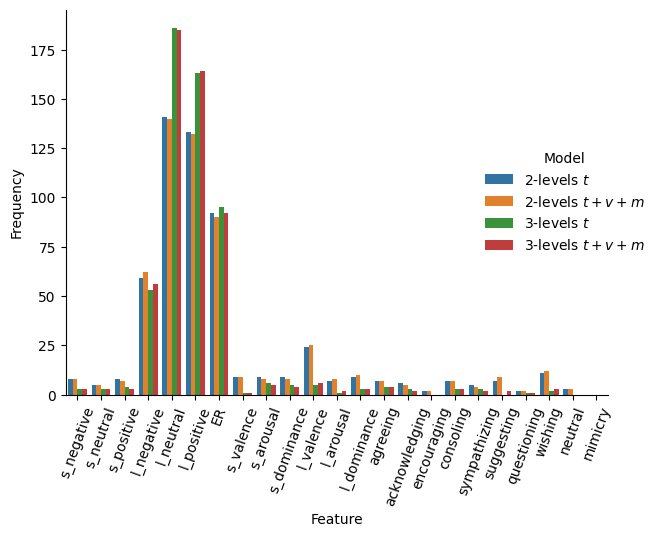

In [9]:
import matplotlib.pyplot as plt

feature_file_3 = pd.read_csv(current_dir + '/features_master_file.csv')
feature_file_2 = pd.read_csv(current_dir + '/features_binary_file.csv')

feature_file_3



frequency_dic_txt_3 = {}
for att in att_lst:
    frequency_dic_txt_3.update({att: 0})
for j in range(len(feature_file_3['influential_txt'])):
    feat_list = eval(feature_file_3['influential_txt'][j])
    for i in range(len(feat_list)):
        #if(feat_list[i][0] == 'l_word_len'):
        #    print(f"{feat_list} {j} {feature_file_3['speaker_utterance'][j]} {feature_file_3['listener_utterance'][j]}")
        frequency_dic_txt_3[feat_list[i][0]] += 1
        #print(feat_list[i][0])
frequency_dic_txt_3.pop('l_word_len')
frequency_dic_txt_3.pop('s_word_len')


frequency_dic_vid_3 = {}
for att in att_lst:
    frequency_dic_vid_3.update({att: 0})
for j in range(len(feature_file_3['influential_txt_vid'])):
    feat_list = eval(feature_file_3['influential_txt_vid'][j])
    for i in range(len(feat_list)):
        #if(feat_list[i][0] == 'l_word_len'):
        #    print(f"{feat_list} {j} {feature_file_3['speaker_utterance'][j]} {feature_file_3['listener_utterance'][j]}")
        frequency_dic_vid_3[feat_list[i][0]] += 1
        #print(feat_list[i][0])
frequency_dic_vid_3.pop('l_word_len')
frequency_dic_vid_3.pop('s_word_len')



frequency_dic_txt_2 = {}
for att in att_lst:
    frequency_dic_txt_2.update({att: 0})
for j in range(len(feature_file_2['influential_txt'])):
    feat_list = eval(feature_file_2['influential_txt'][j])
    for i in range(len(feat_list)):
        #if(feat_list[i][0] == 'l_word_len'):
        #    print(f"{feat_list} {j} {feature_file_3['speaker_utterance'][j]} {feature_file_3['listener_utterance'][j]}")
        frequency_dic_txt_2[feat_list[i][0]] += 1
        #print(feat_list[i][0])
frequency_dic_txt_2.pop('l_word_len')
frequency_dic_txt_2.pop('s_word_len')



frequency_dic_vid_2 = {}
for att in att_lst:
    frequency_dic_vid_2.update({att: 0})
for j in range(len(feature_file_2['influential_txt_vid'])):
    feat_list = eval(feature_file_2['influential_txt_vid'][j])
    for i in range(len(feat_list)):
        #if(feat_list[i][0] == 'l_word_len'):
        #    print(f"{feat_list} {j} {feature_file_3['speaker_utterance'][j]} {feature_file_3['listener_utterance'][j]}")
        frequency_dic_vid_2[feat_list[i][0]] += 1
        #print(feat_list[i][0])
frequency_dic_vid_2.pop('l_word_len')
frequency_dic_vid_2.pop('s_word_len')

dict_list = [frequency_dic_txt_2, frequency_dic_vid_2, frequency_dic_txt_3, frequency_dic_vid_3]


frequency_dic = {'Model': ['2-levels $t$', '2-levels $t+v+m$', '3-levels $t$', '3-levels $t+v+m$']}
for att in att_lst:
    frequency_dic.update({att: []})
frequency_dic.pop('l_word_len')
frequency_dic.pop('s_word_len')



for dict in dict_list:
    for key in dict:
        frequency_dic[key].append(dict[key])

print(frequency_dic)


df_frequency = pd.DataFrame.from_dict(frequency_dic)
df_frequency = df_frequency.rename(columns={"valence_speaker": "s_valence", "arousal_speaker": "s_arousal","dominance_speaker": "s_dominance","valence_listener": "l_valence", "arousal_listener": "l_arousal","dominance_listener": "l_dominance","predictions_ER": "ER"})





print(df_frequency)

for x in dict_list[1:]: 
    continue

dfm = pd.melt(df_frequency, id_vars="Model", var_name="feature", value_name="frequency")

bar_plot = plt.figure(figsize=(7, 5))
ax = sns.barplot(x='feature', y='frequency', hue='Model', data=dfm)
ax.spines[['top', 'right']].set_visible(False)
ax.xaxis.set_tick_params(rotation=70)
ax.set_xlabel('Feature')
ax.set_ylabel('Frequency')

sns.move_legend(ax, bbox_to_anchor=(0.75, 0.5), loc='center left', frameon=False)

bar_plot.savefig(current_dir+"/graphs/top_influential_plot.svg",bbox_inches='tight') 



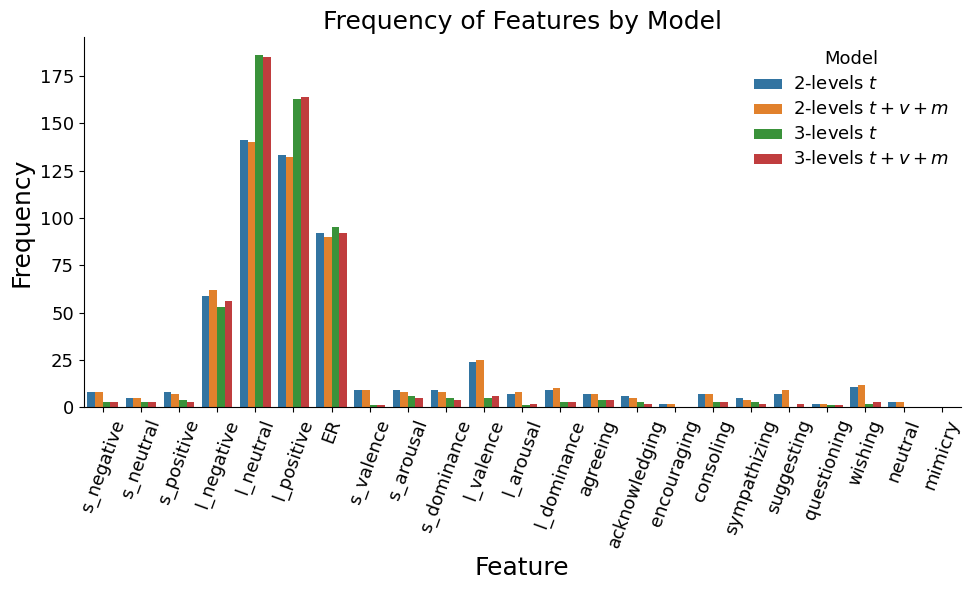

In [37]:

# Create the bar plot with increased bar width
bar_plot = plt.figure(figsize=(10, 6))
ax = sns.barplot(x='feature', y='frequency', hue='Model', data=dfm, width=0.8)  # Adjust the width as needed

# Customize the plot
ax.spines[['top', 'right']].set_visible(False)
ax.xaxis.set_tick_params(rotation=70)
ax.set_xlabel('Feature', fontsize=18)  # Increased font size
ax.set_ylabel('Frequency', fontsize=18)  # Increased font size
ax.set_title('Frequency of Features by Model', fontsize=18)  # Increased font size

# Increase font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=13)

# Move the legend and increase its font size
sns.move_legend(ax, bbox_to_anchor=(0.75, 1), loc='upper left', frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize=13)  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=13)  # for legend title

# Show the plot
plt.tight_layout()
plt.savefig(current_dir+'/graphs/bar_plot.pdf', format='pdf')
plt.show()

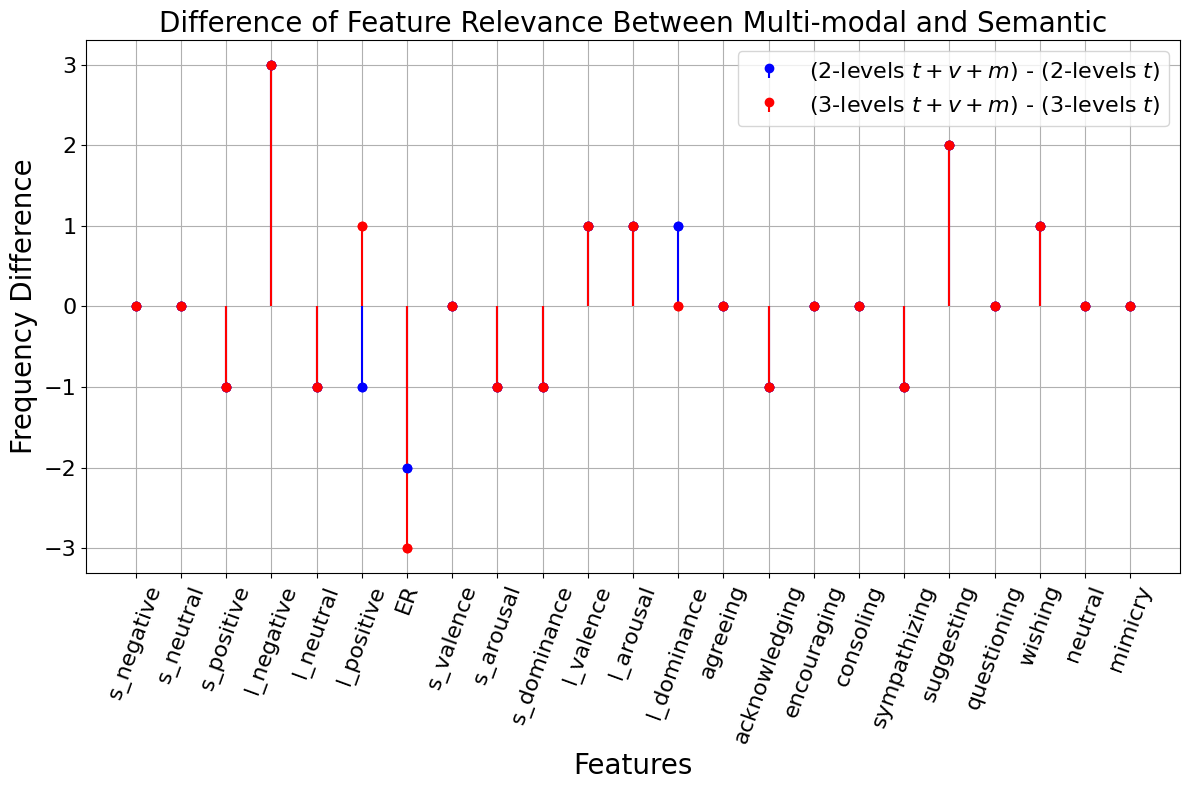

In [38]:
# Calculate the differences
df_frequency

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_frequency is your DataFrame
# Example structure of df_frequency:
# df_frequency = pd.DataFrame({
#     'Model': ['model1', 'model2', 'model3', 'model4'],
#     'feature1': [value1, value2, value3, value4],
#     'feature2': [value5, value6, value7, value8],
#     'feature3': [value9, value10, value11, value12]
# })

# Exclude the "Model" column and calculate the differences
differences_1_0 = df_frequency.iloc[1, 1:] - df_frequency.iloc[0, 1:]
differences_3_2 = df_frequency.iloc[3, 1:] - df_frequency.iloc[2, 1:]

# Create the lollipop plot
plt.figure(figsize=(12, 8))

# Plot differences between row 1 and row 0
plt.stem(differences_1_0.index, differences_1_0.values, basefmt=" ", linefmt='b-', markerfmt='bo', label='(2-levels $t+v+m$) - (2-levels $t$)', use_line_collection=True)
plt.scatter(differences_1_0.index, differences_1_0.values, color='blue', zorder=3)

# Plot differences between row 3 and row 2
plt.stem(differences_3_2.index, differences_3_2.values, basefmt=" ", linefmt='r-', markerfmt='ro', label='(3-levels $t+v+m$) - (3-levels $t$)', use_line_collection=True)
plt.scatter(differences_3_2.index, differences_3_2.values, color='red', zorder=3)

# Customize the plot
plt.title('Difference of Feature Relevance Between Multi-modal and Semantic', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.ylabel('Frequency Difference', fontsize=20)
plt.grid(True)
plt.xticks(rotation=70, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)



plt.tight_layout()
plt.savefig(current_dir+'/graphs/lollipop_plot.pdf', format='pdf')

# Show the plot
plt.show()

# Inter annotator agreement



In [218]:

from sklearn.metrics import cohen_kappa_score

y1 = ["negative", "positive", "negative", "neutral", "positive"]

y2 = ["negative", "positive", "negative", "neutral", "negative"]

cohen_kappa_score(y1, y2)



video_exchanges_df = pd.read_csv(groups_dir + '/exchanges/video_exchanges_disconsensus.csv')
video_exchanges_df = video_exchanges_df[video_exchanges_df['usable'] != 0]
video_exchanges_df = video_exchanges_df[video_exchanges_df['final_label'] != 0]

video_exchanges_df['empathy_1_3'] = video_exchanges_df.apply(lambda x: 1 if (x['empathy_1'] == 2 or x['empathy_1'] == 1)  else (2 if x['empathy_1'] == 3 else 3), axis = 1)
video_exchanges_df['empathy_2_3'] = video_exchanges_df.apply(lambda x: 1 if (x['empathy_2'] == 2 or x['empathy_2'] == 1)  else (2 if x['empathy_2'] == 3 else 3), axis = 1)


video_exchanges_df['empathy_1_2'] = video_exchanges_df.apply(lambda x: 1 if (x['empathy_1_3'] == 1)  else 2, axis = 1)
video_exchanges_df['empathy_2_2'] = video_exchanges_df.apply(lambda x: 1 if (x['empathy_2_3'] == 1)  else 2, axis = 1)
video_exchanges_df['final_label_binary'] = video_exchanges_df.apply(lambda x: 1 if (x['final_label'] == 1)  else 2, axis = 1)



video_exchanges_df.drop(video_exchanges_df[video_exchanges_df.id == 'sub_14_conv_4'].index, inplace=True)
video_exchanges_df.drop(video_exchanges_df[video_exchanges_df.id == 'sub_13_conv_7'].index, inplace=True)
video_exchanges_df.drop(video_exchanges_df[video_exchanges_df.id == 'sub_12_conv_7'].index, inplace=True)
video_exchanges_df.drop(video_exchanges_df[video_exchanges_df.id == 'sub_12_conv_7'].index, inplace=True)
video_exchanges_df.drop(video_exchanges_df[video_exchanges_df.id == 'sub_7_conv_1'].index, inplace=True)
video_exchanges_df = video_exchanges_df.reset_index(drop=True)

video_exchanges_df.to_csv(groups_dir + '/exchanges/video_exchanges_disconsensus_reduced.csv', index= False)

def get_metrics(df, predictions,actual):
    modified_df = df.copy()
    modified_df = modified_df.rename(columns={actual: "empathy"})
    acc = accuracy_score(modified_df["empathy"],modified_df[predictions])
    cem_score = cem.get_cem(modified_df[predictions]-1,modified_df[["empathy"]])
    pre = precision_score(modified_df["empathy"],modified_df[predictions], average='weighted')
    f1 = f1_score(modified_df["empathy"],modified_df[predictions], average='weighted')
    rec = recall_score(modified_df["empathy"],modified_df[predictions], average='weighted')
    return [acc,cem_score,pre,f1,rec,predictions]

cohen_kappa_index_3 = cohen_kappa_score(video_exchanges_df['empathy_1_3'], video_exchanges_df['empathy_2_3'])
metrics_1_3 = get_metrics(video_exchanges_df, 'empathy_1_3', 'final_label')
metrics_2_3 = get_metrics(video_exchanges_df, 'empathy_2_3', 'final_label')
print('three_levels')
print(f'Cohen Kappa: {cohen_kappa_index_3}')
print(f'First annotator: ')
print(metrics_1_3)
print(f'Second annotator: ')
print(metrics_2_3)


cohen_kappa_index_2 = cohen_kappa_score(video_exchanges_df['empathy_1_2'], video_exchanges_df['empathy_2_2'])
metrics_1_2 = get_metrics(video_exchanges_df, 'empathy_1_2', 'final_label_binary')
metrics_2_2 = get_metrics(video_exchanges_df, 'empathy_2_2', 'final_label_binary')

print('two_levels')
print(f'Cohen Kappa: {cohen_kappa_index_2}')
print(f'First annotator: ')
print(metrics_1_2)
print(f'Second annotator: ')
print(metrics_2_2)


with open(groups_dir + '/exchanges/metrics_for_annotators.txt', 'a') as f:
    f.seek(0)
    f.write(f'3-levels')
    f.write('\n')   
    f.write(f'Cohen Kappa: {cohen_kappa_index_3}')
    f.write('\n')
    f.write(f'First annotator: {metrics_1_3}')
    f.write('\n')
    f.write(f'Second annotator: {metrics_2_3}')
    f.write('\n')
    f.write(f'2-levels')
    f.write('\n')   
    f.write(f'Cohen Kappa: {cohen_kappa_index_2}')
    f.write('\n')
    f.write(f'First annotator: {metrics_1_2}')
    f.write('\n')
    f.write(f'Second annotator: {metrics_2_2}')
    f.write('\n')





metric_to_num = {'accuracy': 0, 'cem': 1, 'precision': 2, 'f1': 3,'recall': 4, 'name': 5}



metrics_list = [metrics_1_2,metrics_2_2,metrics_1_3,metrics_2_3]

accuracies = []
cems = []
precisions = []
f1s = []
recalls = []
names = []

for item in metrics_list:
    accuracies.append(item[metric_to_num['accuracy']])
    cems.append(item[metric_to_num['cem']])
    precisions.append(item[metric_to_num['precision']])
    f1s.append(item[metric_to_num['f1']])
    recalls.append(item[metric_to_num['recall']])
    names.append(item[metric_to_num['name']])

data = {'name': names, 'accuracy': accuracies, 'cem': cems,'precision': precisions,'f1': f1s,'recall': recalls }
metrics_df = pd.DataFrame.from_dict(data)
metrics_df.to_csv(groups_dir + '/exchanges/performance_metrics.csv', index=False)





three_levels
Cohen Kappa: 0.19805000994892874
First annotator: 
[0.677570093457944, 0.788342860256806, 0.6573521154821416, 0.6650813102749017, 0.677570093457944, 'empathy_1_3']
Second annotator: 
[0.7242990654205608, 0.8207543287454683, 0.7398532279715321, 0.7283568295877095, 0.7242990654205608, 'empathy_2_3']
two_levels
Cohen Kappa: 0.3617136659436009
First annotator: 
[0.8317757009345794, 0.867199538077584, 0.8378230767199958, 0.8329780545417655, 0.8317757009345794, 'empathy_1_2']
Second annotator: 
[0.8598130841121495, 0.8791536162846394, 0.8626797127521096, 0.8572367469800333, 0.8598130841121495, 'empathy_2_2']


# Experiment order

In [42]:
import random
import math
import itertools
import pandas as pd



plutchik_emo_dic = {0:'anger', 1: 'disgust', 2: 'fear', 3: 'joy', 4: 'anticipation', 5: 'sadness', 6: 'surprise' , 7: 'trust'}
empathy_level_dic = {0: 'low', 1: 'medium', 2: 'high'}

# this only works for Iterable[Iterable]
def is_latin_rectangle(rows):
    valid = True
    for row in rows:
        if len(set(row)) < len(row):
            valid = False
    if valid and rows:
        for i, val in enumerate(rows[0]):
            col = [row[i] for row in rows]
            if len(set(col)) < len(col):
                valid = False
                break
    return valid

def is_latin_square(rows):
    return is_latin_rectangle(rows) and len(rows) == len(rows[0])

# : prepare the input
n = 8
items = list(range(1, n + 1))
# shuffle items
random.shuffle(items)
# number of permutations



def latin_square(items, shuffle=True):
    result = []
    for elems in itertools.permutations(items):
        valid = True
        for i, elem in enumerate(elems):
            orthogonals = [x[i] for x in result] + [elem]
            if len(set(orthogonals)) < len(orthogonals):
                valid = False
                break
        if valid:
            result.append(elems)
    if shuffle:
        random.shuffle(result)
    return result

ltn_sq_1 = latin_square(items)
for row in ltn_sq_1:
    print(row)
print(is_latin_square(ltn_sq_1))

type(ltn_sq_1)

experiment_squares = []

#print(experiment_squares[0][1])

for i in range(n):
    experiment_squares.append(list(ltn_sq_1[i]))

for i in range(n):
    for j in range(n):
        experiment_squares[i][j] = (plutchik_emo_dic[experiment_squares[i][j]-1], random.choice(['low','medium','high']))


for row in experiment_squares:
    print(row)


#for item in experiment_squares: 
#    print(item)

latin_sqr_df = pd.DataFrame(experiment_squares).T


print(latin_sqr_df)

number_of_square = 2

latin_sqr_df.to_csv('./useful_database_subsets/experiment_square_'+str(number_of_square)+'.csv')

#random.choice(['low','medium','high'])

(6, 4, 7, 8, 1, 5, 2, 3)
(7, 8, 6, 4, 2, 3, 1, 5)
(3, 2, 5, 1, 8, 7, 4, 6)
(1, 5, 2, 3, 6, 4, 7, 8)
(5, 1, 3, 2, 4, 6, 8, 7)
(2, 3, 1, 5, 7, 8, 6, 4)
(4, 6, 8, 7, 5, 1, 3, 2)
(8, 7, 4, 6, 3, 2, 5, 1)
True
[('sadness', 'low'), ('joy', 'high'), ('surprise', 'medium'), ('trust', 'high'), ('anger', 'low'), ('anticipation', 'low'), ('disgust', 'high'), ('fear', 'high')]
[('surprise', 'high'), ('trust', 'low'), ('sadness', 'high'), ('joy', 'high'), ('disgust', 'medium'), ('fear', 'high'), ('anger', 'high'), ('anticipation', 'high')]
[('fear', 'high'), ('disgust', 'high'), ('anticipation', 'medium'), ('anger', 'high'), ('trust', 'medium'), ('surprise', 'medium'), ('joy', 'low'), ('sadness', 'medium')]
[('anger', 'high'), ('anticipation', 'medium'), ('disgust', 'low'), ('fear', 'medium'), ('sadness', 'medium'), ('joy', 'high'), ('surprise', 'high'), ('trust', 'medium')]
[('anticipation', 'low'), ('anger', 'high'), ('fear', 'high'), ('disgust', 'medium'), ('joy', 'high'), ('sadness', 'high'), (